# *CoastSat*: Punta de Lobos, Chile



## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [36]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import ee
ee.Initialize(project='ee-rafarencoretg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Retrieval of the images from GEE

In [37]:
country_info = {
    "country": "CHILE",
    "country_code": "chi",
    "region": {
        "OHIGGINS": {
            "chi0345": {
                "name": "PLAYA_MATANZAS",
                "slope": 0.074
            },
            "chi0346": {
                "name": "PLAYA_PUPUYA",
                "slope": 0.076
            },
            "chi0356": {
                "name": "PLAYA_PUNTA_DE_LOBOS",
                "slope": 0.075
            }
        }
    }
}

In [55]:
# Sitio de estudio y su codigo
region_name = "OHIGGINS"
geojson_folder = 'CoastSat_Web'
beach = "chi0356"
sitename = country_info["region"][region_name][beach]["name"]
slope = country_info["region"][region_name][beach]["slope"]

# Region de interes (longitud, latitud) en formato geojson
geojson_polygon = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f"{beach}_polygon.geojson")
polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

# Rango de fechas
dates = ['2023-12-31', '2024-12-31']

# Satelites (misiones) ['L5','L7','L8','L9','S2']
sat_list = ['L8','L9','S2']

# Directorio de almacenamiento
filepath = os.path.join(os.getcwd(), 'data')

# Diccionario con la información del sitio de estudio
inputs = {'region': region_name, 'id': beach, 'sitename': sitename, 'slope': slope, 
          'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'filepath':filepath}


# before downloading the images, check how many images are available for your inputs
print(f'\nIMAGENES DISPONIBLES EN {sitename}')
SDS_download.check_images_available(inputs);


IMAGENES DISPONIBLES EN PLAYA_PUNTA_DE_LOBOS
Number of images available between 2023-12-31 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 41 images
     L9: 37 images
     S2: 181 images
  Total to download: 259 images
L8: 12/41 images already exist, 29 to be downloaded
L9: 11/37 images already exist, 26 to be downloaded
S2: 44/181 images already exist, 137 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 20 images
  Total Tier 2: 20 images


In [56]:
# inputs['include_T2'] = True
print(f"\nDESCARGANDO IMAGENES EN {sitename}")
metadata = SDS_download.retrieve_images(inputs)


DESCARGANDO IMAGENES EN PLAYA_PUNTA_DE_LOBOS
GEE initialized (existing token).
Number of images available between 2023-12-31 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 41 images
     L9: 37 images
     S2: 181 images
  Total to download: 259 images
L8: 12/41 images already exist, 29 to be downloaded
L9: 11/37 images already exist, 26 to be downloaded
S2: 44/181 images already exist, 137 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 20 images
  Total Tier 2: 20 images

L8: 29 images
100%
L9: 26 images
100%
S2: 137 images
100%
Satellite images downloaded from GEE and save in d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS


**If you have already retrieved the images**, just load the metadata file by only running the section below

In [57]:
metadata = SDS_download.get_metadata(inputs)
print(f'\nGRABADO DE METADATA DE {sitename} COMPLETADA')


GRABADO DE METADATA DE PLAYA_PUNTA_DE_LOBOS COMPLETADA


## 2. Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped shorelines (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using **cartesian coordinates** (eastings and northings) and **not spherical coordinates** (lat,lon like WGS84). It is important that you use a local projection otherwise you may introduce errors when intersecting the shorelines with the cross-shore transects.

To quality control each shoreline detection and manually validate the mapped shorelines, the user has two options:
1. Set the parameter `check_detection` to `True`: shows each mapped shoreline and user can accept it or discard it.
2. Set the parameter `adjust_detection` to `True` allows the user to adjust the position of the shoreline by modifying the Otsu threshold interactively.

Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to `True`. 

The other parameters are for advanced users only (which understand what is going on in the background) and are described in the README file of the Github repository.

In [58]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 32718,       # epsg code of spatial reference system desired for the output #28356 #4326 #Codigo en cartesian coordinate system
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

### Digitize a reference shoreline [HIGHLY RECOMMENDED]
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [59]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline has been saved in d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS


### Batch shoreline detection
Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [60]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
L8:   100%
L9:   100%
S2:   2%Could not map shoreline for this image: 2024-01-08-14-52-23_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   5%Could not map shoreline for this image: 2024-01-18-14-52-23_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   9%Could not map shoreline for this image: 2024-02-02-14-52-19_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   11%Could not map shoreline for this image: 2024-02-07-14-52-23_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   13%Could not map shoreline for this image: 2024-02-12-14-52-21_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   14%Could not map shoreline for this image: 2024-02-17-14-52-25_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   16%Could not map shoreline for this image: 2024-02-22-14-52-21_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   19%Could not map shoreline for this image: 2024-03-03-14-52-24_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   21%Could not map shoreline for this image: 2024-03-08-14-52-18_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   2

Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [61]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

40 duplicates
2 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [62]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

Simple plot of the mapped shorelines. The coordinates are stored in the output dictionnary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

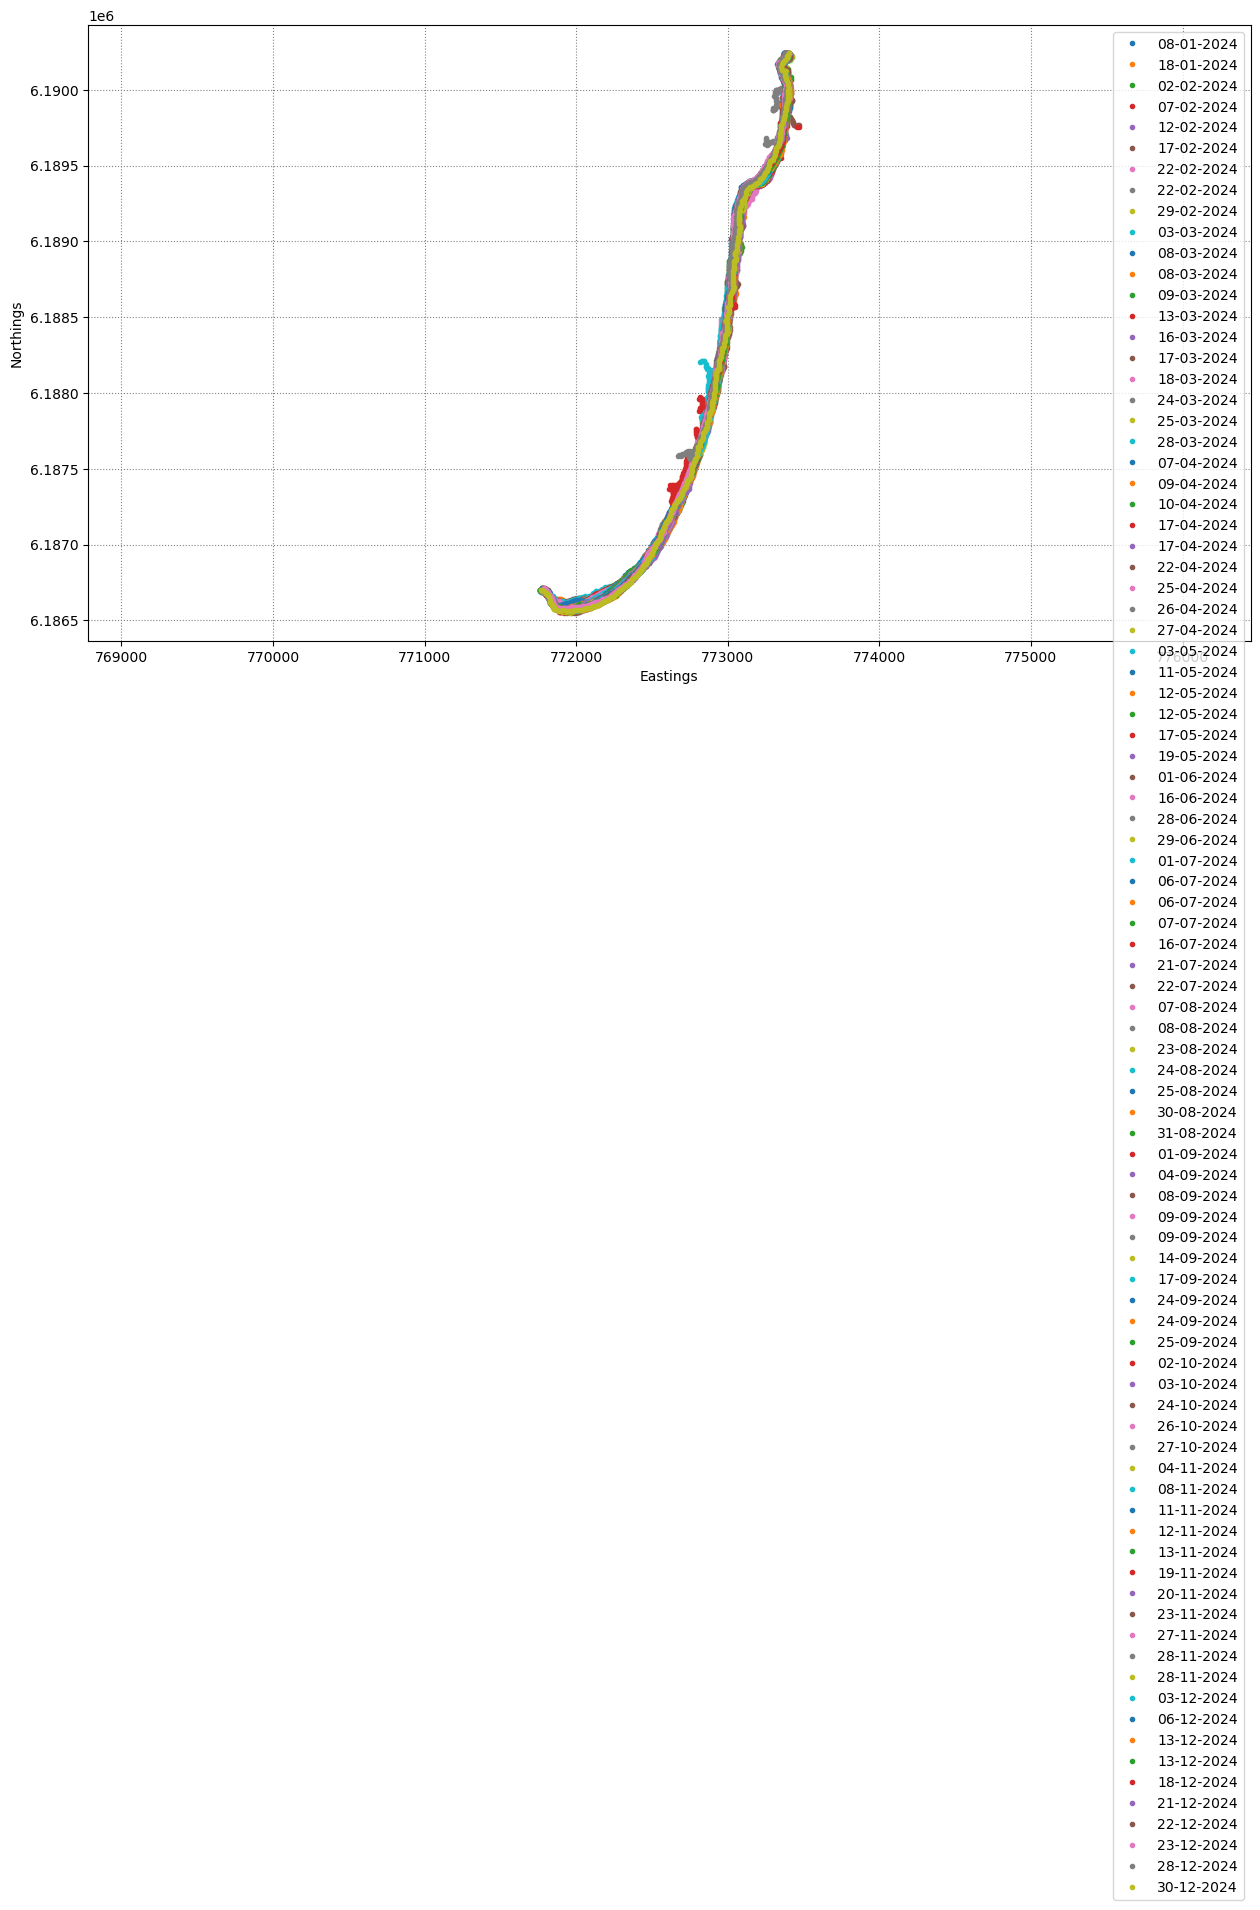

In [63]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])

plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend();

## 3. Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [64]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

40 duplicates
2 bad georef


**Option 2**: the user can load the transect coordinates (make sure the coordinate reference system (CRS) is the same as defined previously in `settings['output_epsg]`) from a .geojson file by calling:

In [65]:
import geopandas as gpd

geojson_file = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f'{beach}_transects_transformed.geojson')
gdf = gpd.read_file(geojson_file,driver='GeoJSON')
transects = SDS_tools.transects_from_geojson(geojson_file)

40 transects have been loaded coordinates are in epsg:32718


Plot the location of the transects, make sure they are in the right location with the origin always landwards! Also check that the transects are intersecting the mapped shorelines.

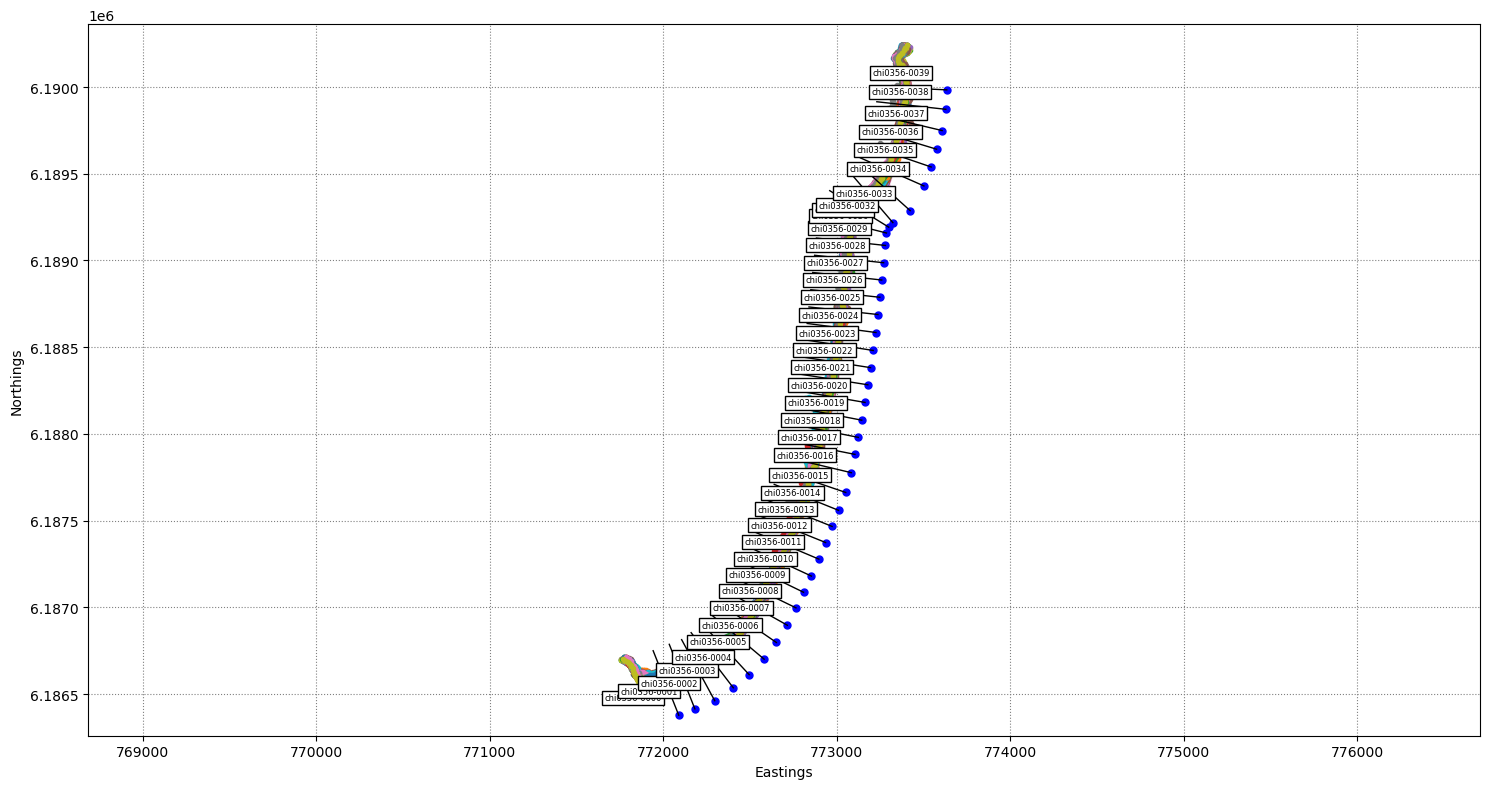

In [66]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')

for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())): #for key in seccion:  
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'), fontsize=6)

Now, we intersect 2D shorelines with the shore-normal transects to obtain time-series of cross-shore distance along each transect.

One way is to simply compute the intersection as the median of the shoreline points within a certain range (`along_dist`).

However, the shorelines can often be noisy (small loops, double intersections, etc), therefore a few parameters can be set to quality-control the intersections between tranects and shorelines with a more advanced function `compute_intersection_QC()`:
- `along_dist`: (in metres),
    alongshore distance to caluclate the intersection (median of points 
    within this distance). 
- `min_points`:  minimum number of shoreline points to calculate an intersection.
- `max_std`: (in metres) maximum STD for the shoreline points within the alongshore range, 
    if STD is above this value a NaN is returned for this intersection.
- `max_range`: (in metres) maximum RANGE for the shoreline points within the alongshore range, 
    if RANGE is above this value a NaN is returned for this intersection.
- `min_chainage`: (in metres) furthest distance landward of the transect origin that an intersection is 
    accepted, beyond this point a NaN is returned.
- `multiple_inter`: ('auto','nan','max') defines how to deal with multiple shoreline intersections
- `auto_prc`: (value between 0 and 1) by default 0.1, percentage of the time that a multiple intersection needs to be present to use the max in auto mode

Default parameters for the more quality-controlled intersections are provided below and should work in most cases (leave as it is if unsure).

The `multiple_inter` setting helps to deal with multiple shoreline intersections along the same transect. This is quite common, for example when there is a lagoon behind the beach and the transect crosses two water bodies. The function will try to identify this cases and the user can choose whether to:
- `'nan'`: always assign a NaN when there are multile intersections.
- `'max'`: always take the max (intersection the furtherst seaward).
- `'auto'`: let the function decide transect by transect, and if it thinks there are two water bodies, take the max.
If `'auto'` is chosen, the `auto_prc` parameter will define when to use the max, by default it is set to 0.1, which means that the function thinks there are two water bodies if 10% of the time-series show multiple intersections.

In [67]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Plot the time-series of shoreline change along each transect

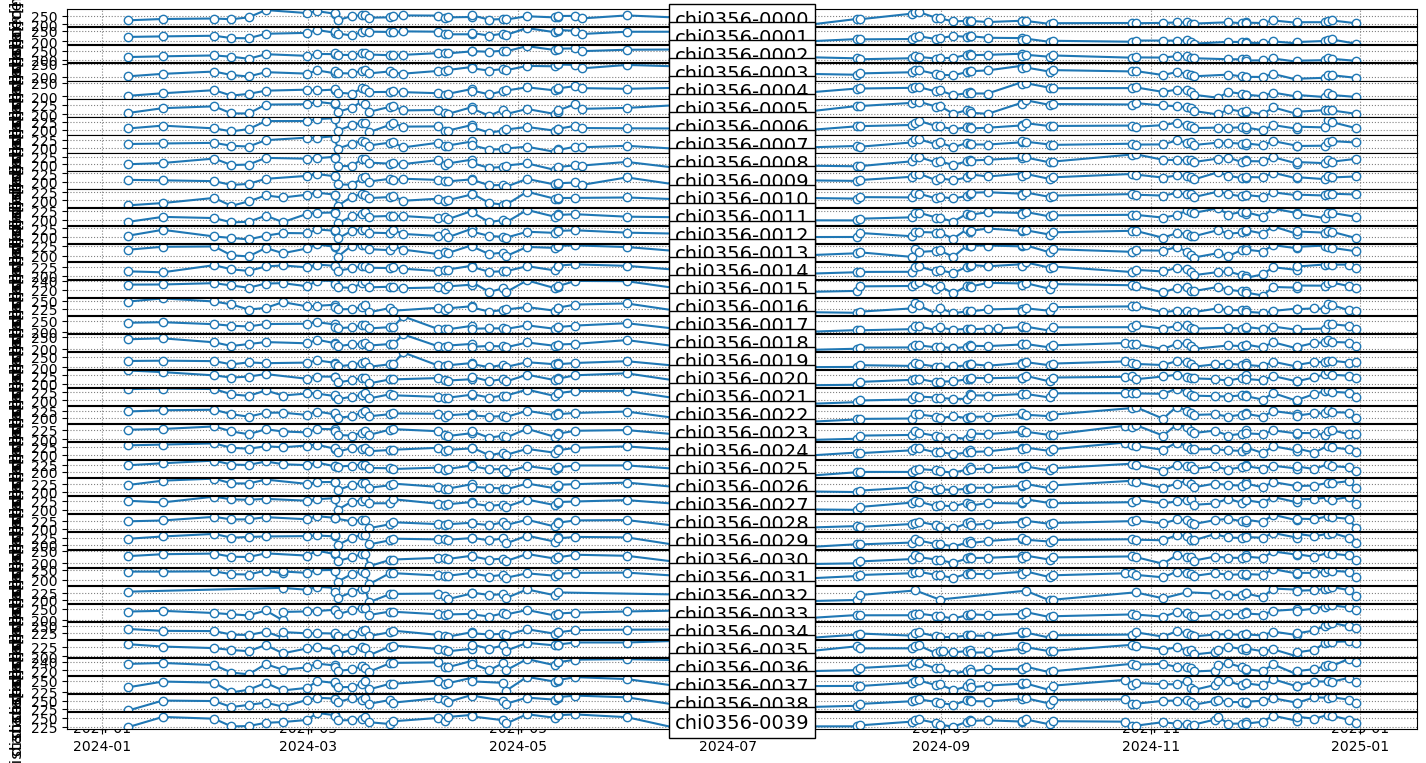

In [68]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
fig.savefig(os.path.join(filepath,'%s_timeseries_raw.jpg'%sitename),dpi=200)

In [69]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\transect_time_series.csv


## 4. Tidal correction

This section shows how to tidally-correct the extracted time-series of shoreline change using time-series of tide level and an estimate of the beach slope.

For this example, measured water levels for Sydney are stored in a csv file located [here](https://github.com/kvos/CoastSat/blob/master/examples/NARRA_tides.csv) and we assume that the beach slope at Narrabeen-Collaroy is 0.1 along all transects.

If you are running a different site, you have two options to get the tide levels:
- **Option 1**: use the [FES2022](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/release-fes22.html) global tide model to predict tide levels at the time of image acquisition. To setup FES2022 on your machine follow the instructions in [this document](https://github.com/kvos/CoastSat/blob/master/doc/FES2022_setup.md).
- **Option 2**: provide your own tide level time-series. When using your own file make sure that the dates are in UTC time, as the CoastSat shorelines are also in UTC, and the datum for the water levels is approx. Mean Sea Level.

We will also see further down how to estimate beach slopes using the [CoastSat.slope](https://github.com/kvos/CoastSat.slope) methodology (integrated here).

**Option 1:** use FES2022 to predict tides

In [22]:
# import coastsat.slope module
from coastsat import SDS_slope
# load pyfes and the global tide model (may take one minute)
import pyfes
filepath_FES = os.path.join(os.pardir,'AVISO','tide_model','fes2022b')
config =  os.path.join(filepath_FES, 'fes2022.yaml')
handlers = pyfes.load_config(config)
ocean_tide = handlers['tide']
load_tide = handlers['radial'] 

MemoryError: Unable to allocate 445. MiB for an array with shape (5401, 10800) and data type complex64

In [ ]:
# get polygon centroid, coordinates to get tides from
centroid = np.mean(polygon[0], axis=0)
print(centroid)
# if longitude is negative add 180 (longitudes are from 0 to 360 in fes)
if centroid[0] < 0: centroid[0] += 180

In [ ]:
# get tides time-series (15 minutes timestep)
date_range = [pytz.utc.localize(datetime.strptime(inputs['dates'][0],'%Y-%m-%d')),
              pytz.utc.localize(datetime.strptime(inputs['dates'][1],'%Y-%m-%d'))]
timestep = 900 # seconds
dates_ts, tides_ts = SDS_slope.compute_tide(centroid, date_range, timestep, ocean_tide, load_tide)
# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_slope.compute_tide_dates(centroid, output['dates'], ocean_tide, load_tide)
# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()
fig.savefig(os.path.join(filepath,'%s_tide_timeseries.jpg'%sitename),dpi=200)

You can also save the prediced tide time-series into a .csv file for later use by uncommenting this cell.

In [ ]:
# tide_data = {'dates':dates_ts,'tide':tides_ts}
# df = pd.DataFrame(tide_data)
# df.to_csv(os.path.join(os.getcwd(),'examples','%s_tides.csv'%sitename),index=False)

**Option 2:** Usar un archivo local con los datos de mareas de alguna estación.

Antes de correr esto, correr el archivo `obtener_marea.ipynb`, dentro de la carpeta Mareas, para generar el archivo que contiene las mareas de la estación de boyeruca.

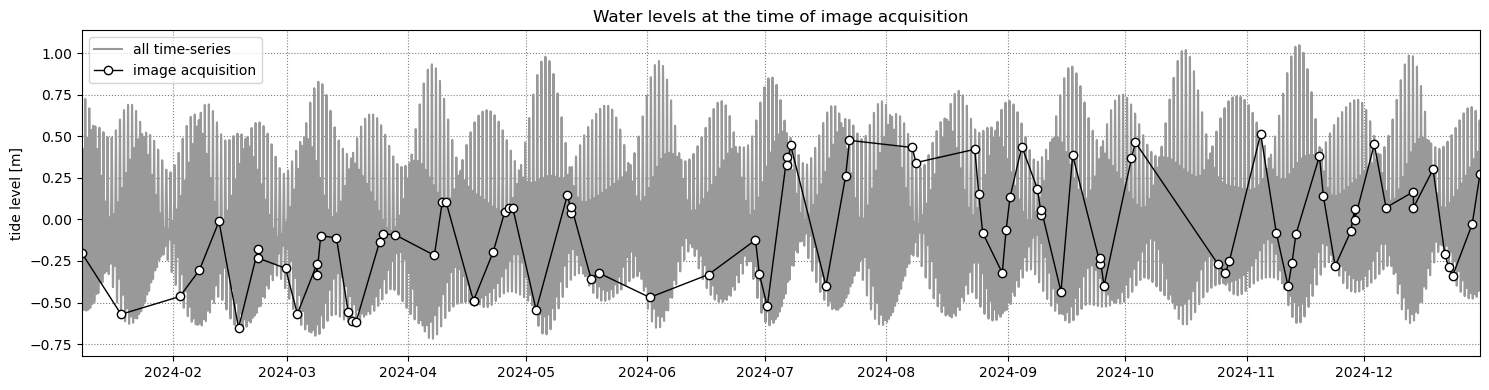

In [70]:
# load the measured tide data
filepath_tides = os.path.join(os.getcwd(),'Mareas', 'mareas_boyeruca_final.csv')
tide_data = pd.read_csv(filepath_tides)

dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tide_data['date']]
tides_ts = np.array(tide_data['tide'])
# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']

#Mi codigo
fechas_timestamp = pd.to_datetime(tide_data['date'])
# Convertir las fechas a un índice de fecha y hora
fechas_index = pd.DatetimeIndex(fechas_timestamp)

# Definir la zona horaria UTC
tz_utc = 'UTC'

# Convertir las fechas al huso horario UTC
fechas_utc = fechas_index.tz_localize(tz_utc)
fechas_utc = pd.to_datetime(fechas_utc)

# Encontrar el índice del valor más cercano en fechas_utc para cada fecha en dates_sat
indices = fechas_utc.searchsorted(dates_sat)

# Ajustar los índices para asegurar que estén dentro del rango
indices = np.clip(indices, 0, len(fechas_utc) - 1)

# Usar los índices para obtener los valores correspondientes en tides_ts
tides_sat = tides_ts[indices]

'''
dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tide'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)
'''

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition');
ax.legend();

Apply tidal correction using a linear slope and a reference elevation to which project all the time-series of cross-shore change (to get time-series at Mean Sea Level, set `reference_elevation` to 0. You also need an estimate of the beach slope. 

Tidally-corrected time-series of the shoreline change along the transects saved as:
d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\transect_time_series_tidally_corrected.csv


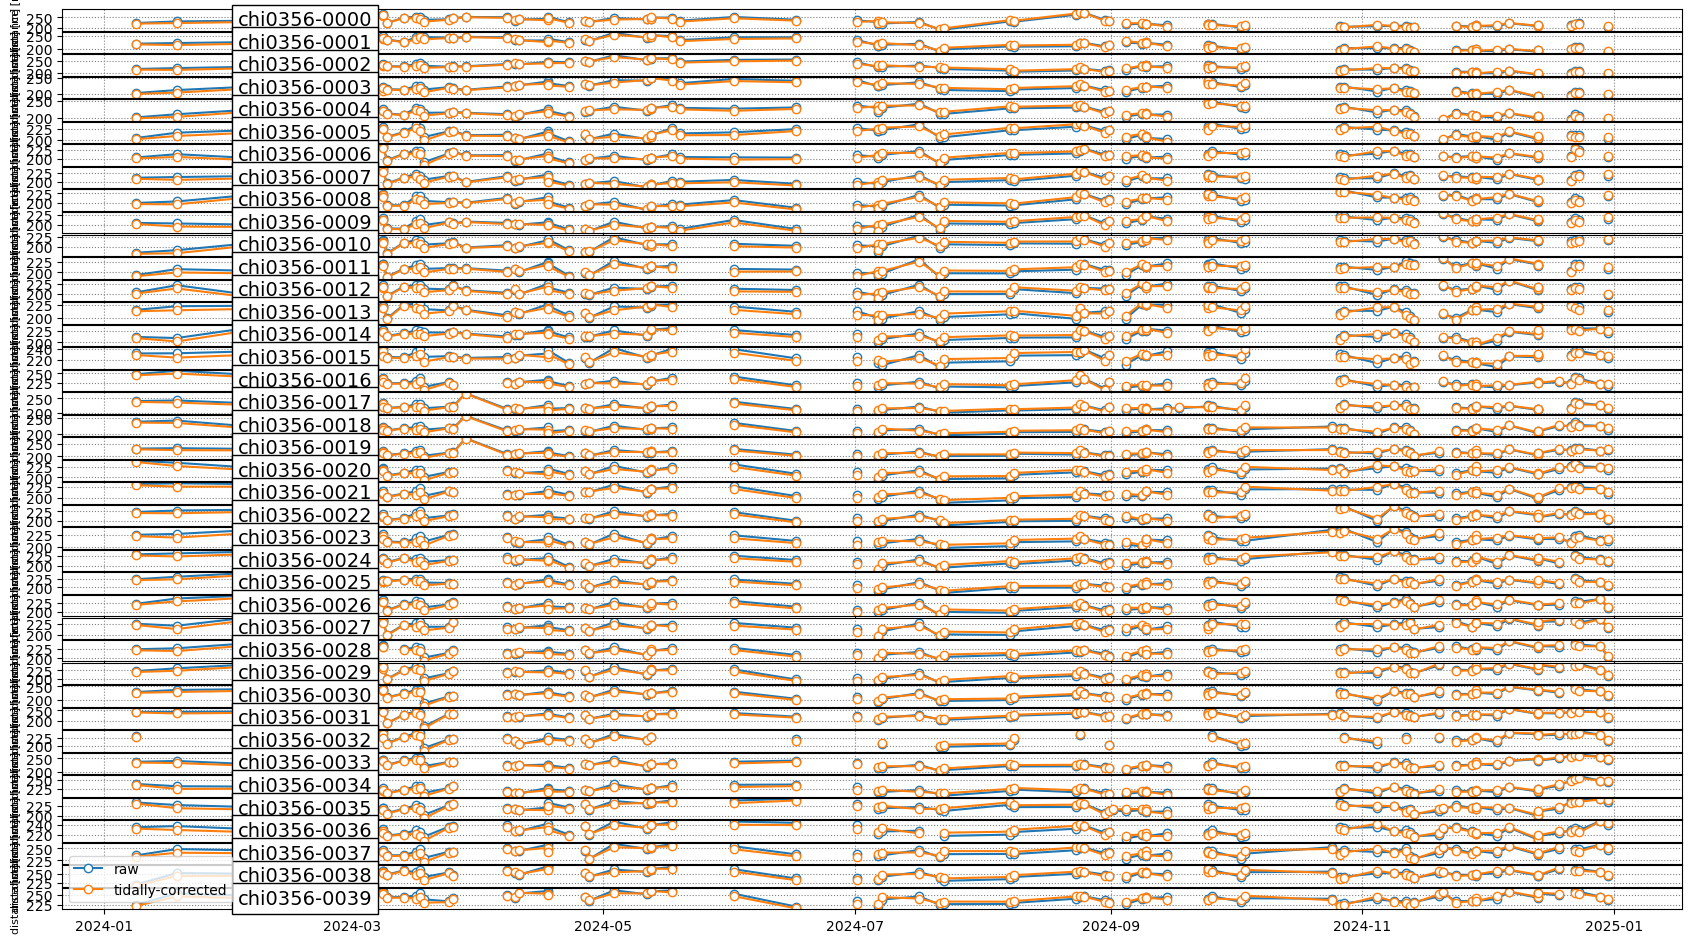

In [71]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[18,10], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w', label='raw')
    ax.plot(output['dates'], cross_distance_tidally_corrected[key], '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=8)
    ax.text(0.15,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend();

## 5. Time-series post-processing

Finally, we can post-process the time-series of shoreline change to remove obvious outliers and spikes in the data and average the time-series over different time-frames (seasonally or monthly).

To demonstrate these functionalities, we load a full time-series of shoreline change at Narrabeen from Landsat imagery between 1984 and 2021. These shorelines were mapped automatically without manual quality control, intersected with the transects and tidally-corrected.

Imagen guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\CoastSat\shorelines_mapped_from_1985.png
Series temporales cargadas y procesadas correctamente.


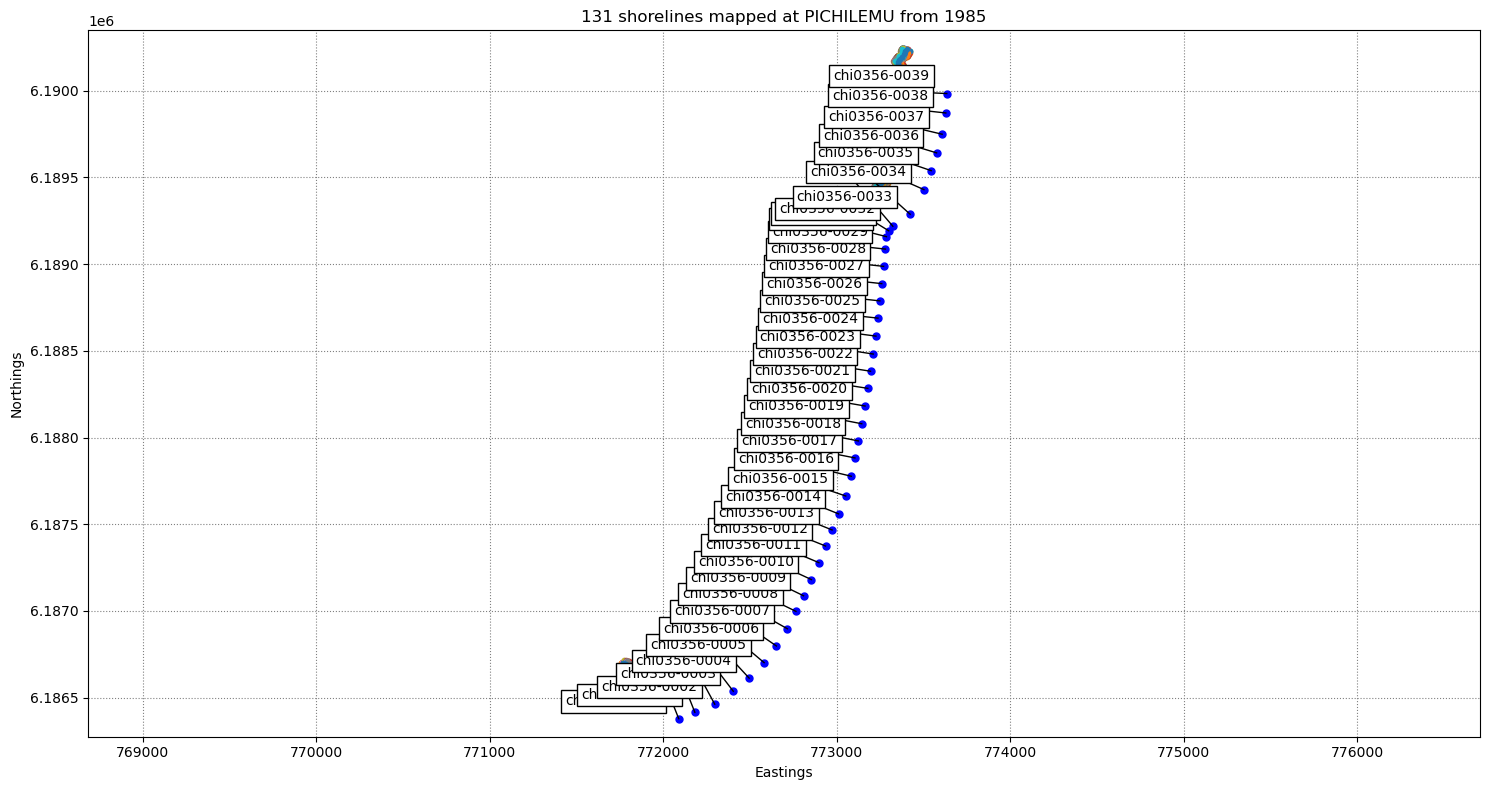

In [72]:
%matplotlib inline
# Cargar las líneas de costa mapeadas desde 1985
filename_output = os.path.join(settings['inputs']['filepath'],
                               settings['inputs']['sitename'],
                               f"{settings['inputs']['sitename']}_output.pkl")


with open(filename_output, 'rb') as f:
    output = pickle.load(f)

# Plotear las líneas de costa mapeadas
fig = plt.figure(figsize=[15, 8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
plt.title(f"{len(output['shorelines'])} shorelines mapped at PICHILEMU from 1985")
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:, 0], sl[:, 1], '.', label=date.strftime('%d-%m-%Y'))

for i, key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0, 0], transects[key][0, 1], 'bo', ms=5)
    plt.plot(transects[key][:, 0], transects[key][:, 1], 'k-', lw=1)
    plt.text(
        transects[key][0, 0] - 100, transects[key][0, 1] + 100, key,
        va='center', ha='right', bbox=dict(boxstyle="square", ec='k', fc='w')
    )

# Guardar la figura
output_image_path = os.path.join(settings['inputs']['filepath'],
                                 settings['inputs']['sitename'],
                                 "Resultados",
                                 "CoastSat")
os.makedirs(output_image_path, exist_ok=True)  # Crear directorio si no existe
image_file_name = os.path.join(output_image_path, "shorelines_mapped_from_1985.png")
plt.savefig(image_file_name, dpi=300)  # Ajusta dpi si es necesario
print(f"Imagen guardada en: {image_file_name}")

# Cargar las series temporales largas (1985-2021)
filepath = os.path.join(settings['inputs']['filepath'],
                        settings['inputs']['sitename'],
                        "transect_time_series_tidally_corrected.csv")
df = pd.read_csv(filepath, parse_dates=['dates'])

# Procesar las series temporales
dates = [_.to_pydatetime() for _ in df['dates']]
cross_distance = dict()
for key in transects.keys():
    cross_distance[key] = np.array(df[key])

print("Series temporales cargadas y procesadas correctamente.")


#### 5.1 Despiking the time-series

The tidally-corrected time-series of shoreline change obtained with the steps above may still contain some outliers (from cloud shadows, false detections etc). The function `SDS_transects.reject_outliers()` was developed to remove obvious outliers in the time-series, by removing the points that do not make physical sense in a shoreline change setting. 

For example, the shoreline can experience rapid erosion after a large storm, but it will then take time to recover and return to its previous state. Therefore, if the shoreline erodes/accretes suddenly of a significant amount (`max_cross_change`) and then immediately returns to its previous state, this spike does not make any physical sense and can be considered an outlier. Additionally, this function also checks that the Otsu thresholds used to map the shoreline are within the typical range defined by `otsu_threshold`, with values outside this range identified as outliers.

In [73]:
# remove outliers in the time-series (coastal despiking)
#No podemos correr esto.. hay un problema en la # de fechas en output y en los archivos creados
settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 89 but size of corresponding boolean axis is 131

We can also plot the Otsu threholds for the shorelines mapped at this site to see if there are any obvious outliers and adjust the values of `otsu_threshold`.

Figura guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\CoastSat\otsu_thresholds.jpg


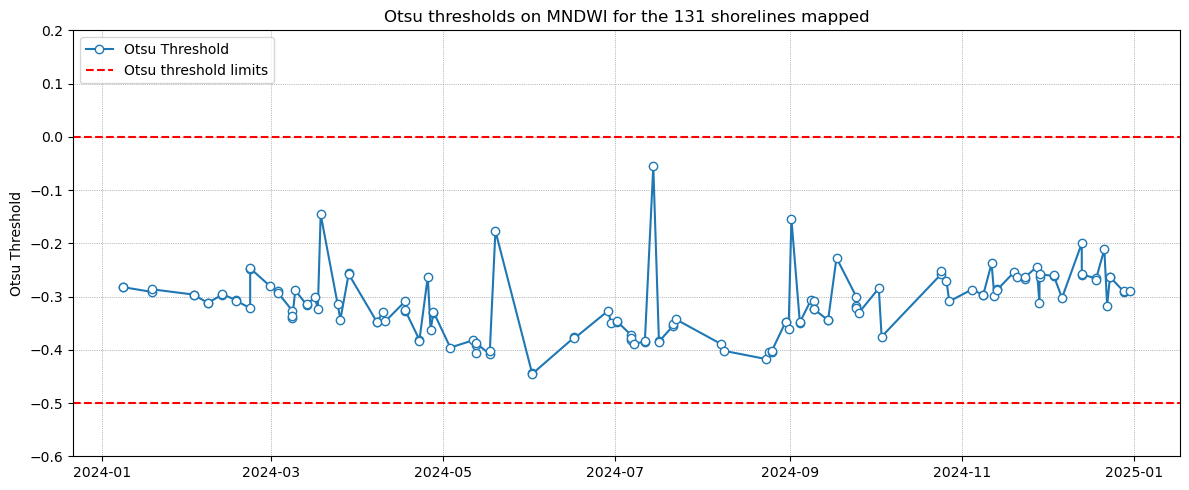

In [74]:
%matplotlib inline

# Crear la figura para los umbrales de Otsu
fig, ax = plt.subplots(1, 1, figsize=[12, 5], tight_layout=True)
ax.grid(which='major', linestyle=':', linewidth=0.5, color='0.5')
ax.plot(output['dates'], output['MNDWI_threshold'], 'o-', mfc='w', label='Otsu Threshold')
ax.axhline(y=-0.5, linestyle='--', color='r', label='Otsu threshold limits')
ax.axhline(y=0, linestyle='--', color='r')
ax.set(
    title=f'Otsu thresholds on MNDWI for the {len(output["shorelines"])} shorelines mapped',
    ylim=[-0.6, 0.2],
    ylabel='Otsu Threshold'
)
ax.legend(loc='upper left')

# Guardar la figura
output_image_path = os.path.join(settings['inputs']['filepath'],
                                 settings['inputs']['sitename'],
                                 "Resultados",
                                 "CoastSat")
os.makedirs(output_image_path, exist_ok=True)  # Crear el directorio si no existe
image_file_name = os.path.join(output_image_path, "otsu_thresholds.jpg")
fig.savefig(image_file_name, dpi=300)  # Ajusta dpi para mayor calidad
print(f"Figura guardada en: {image_file_name}")


In [75]:
outliers = []
for i in range(len(output['MNDWI_threshold'])):
    if output['MNDWI_threshold'][i] >= 0 or output['MNDWI_threshold'][i] <= -0.5:
        outliers.append([i, output['MNDWI_threshold'][i]])
        #print(f'La imagen con indice {i} y fecha {output['dates'][i]} tiene un valor de MNDWI threshold de {output['MNDWI_threshold'][i]}')

#### 5.2 Seasonal averaging and long-term trends

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.seasonal_average()` and calculate the long-term trend with `SDS_transects.calculate_trend`.

Figura de estacionalidad guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Estacional\seasonality_chi0356-0000.png
Figura de estacionalidad guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Estacional\seasonality_chi0356-0001.png
Figura de estacionalidad guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Estacional\seasonality_chi0356-0002.png
Figura de estacionalidad guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Estacional\seasonality_chi0356-0003.png
Figura de estacionalidad guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Estacional\seasonality_chi0356-0004.png
Figura de estacionalidad guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Estacional\seasonality_chi0356-0005.png
Figura de 

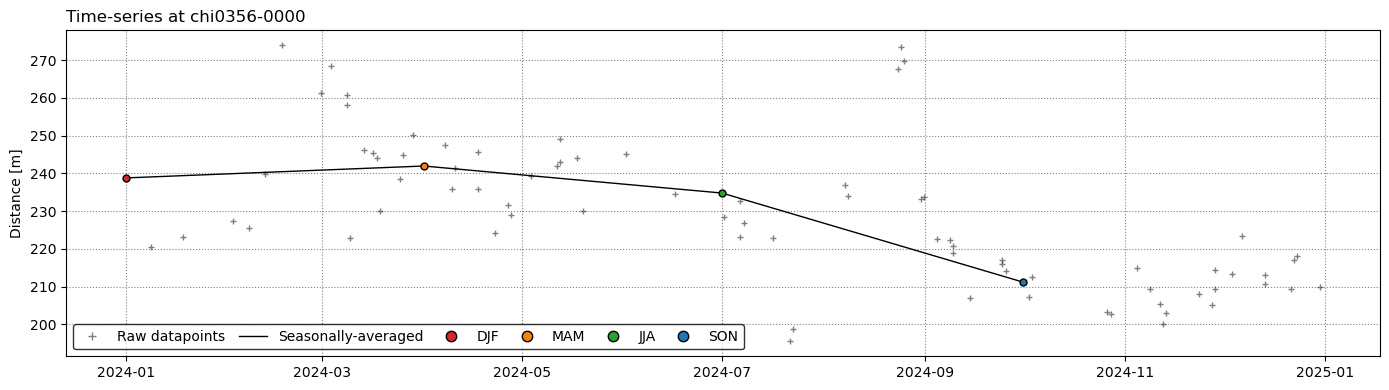

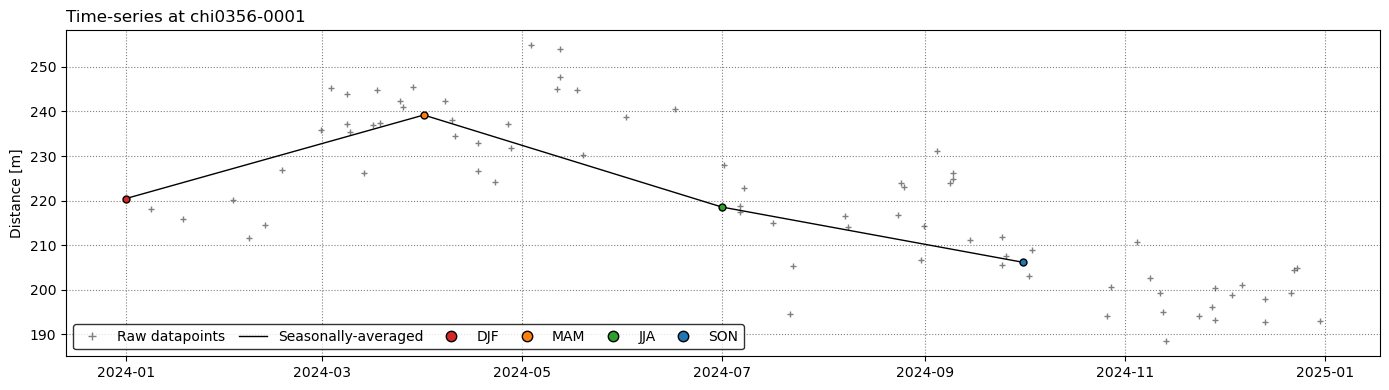

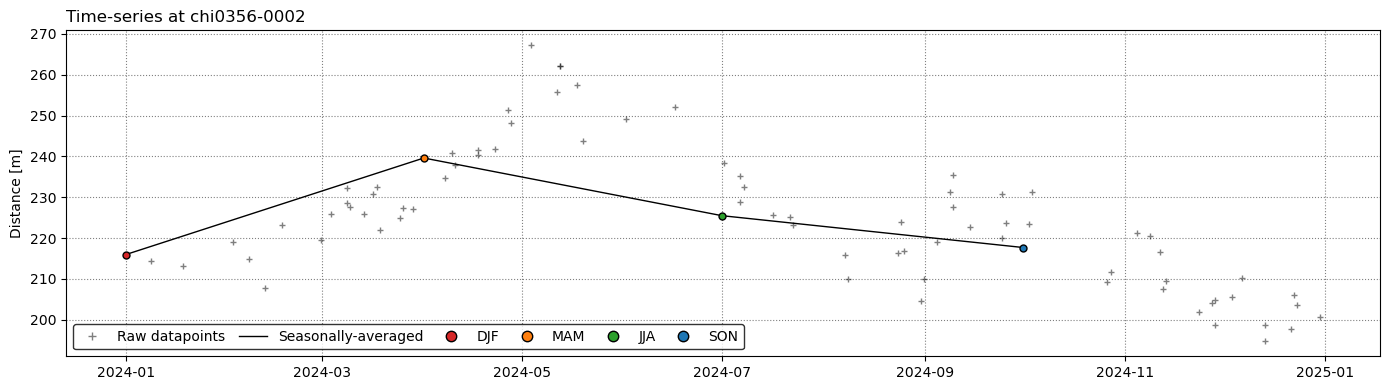

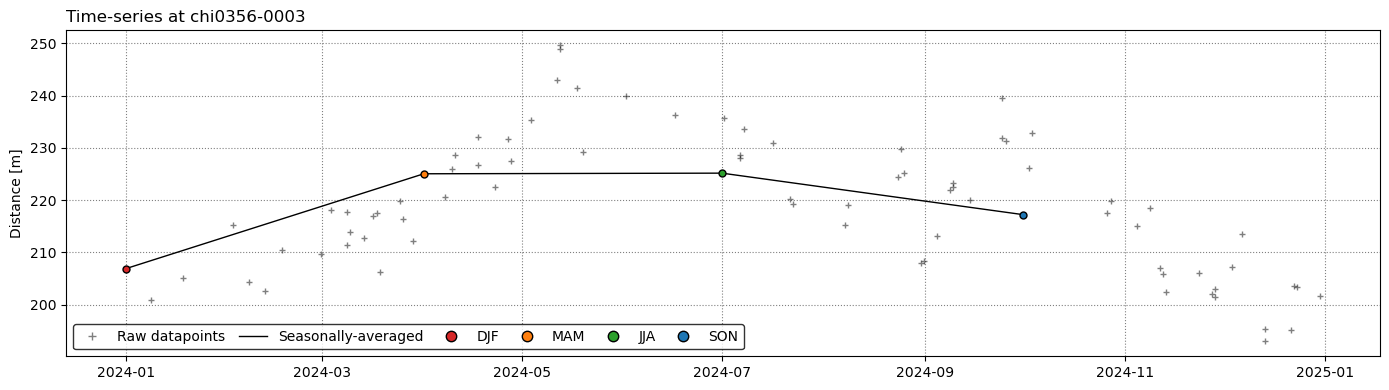

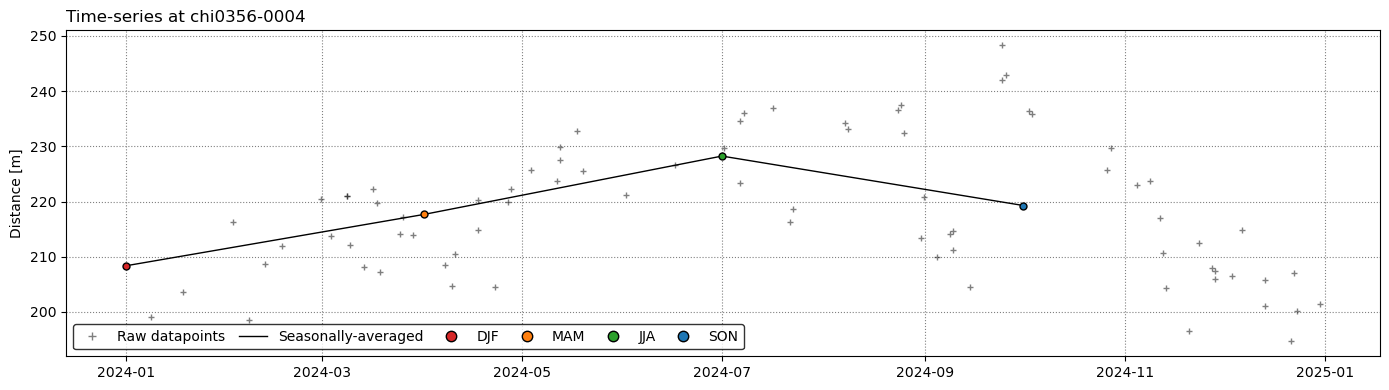

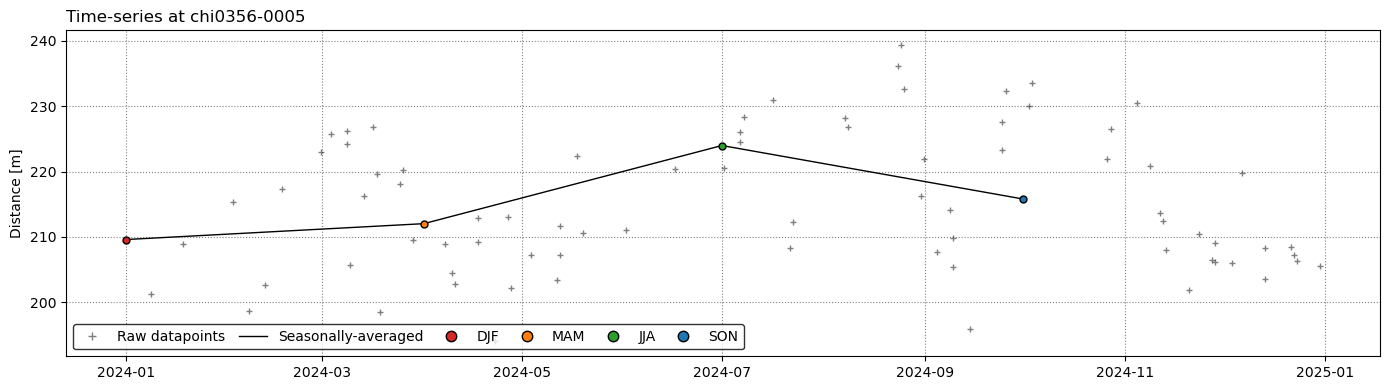

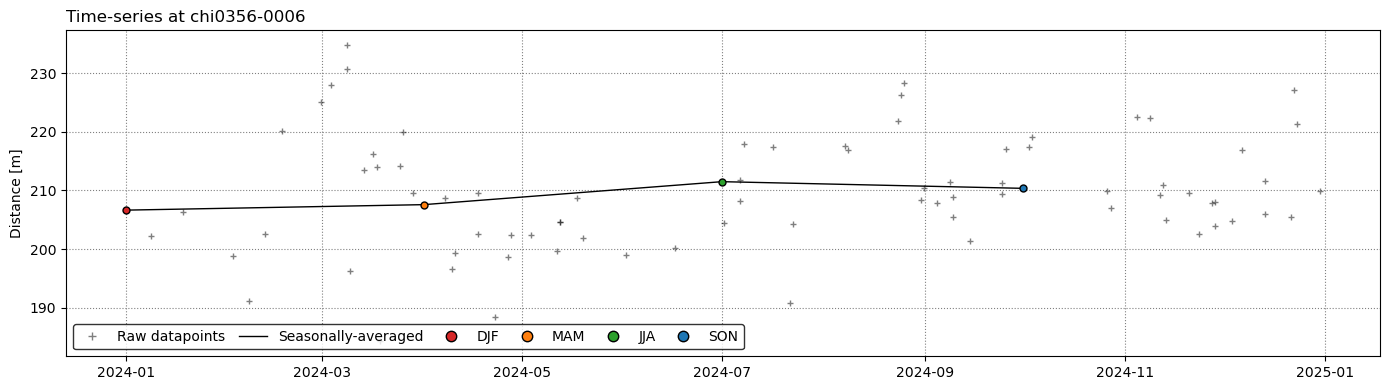

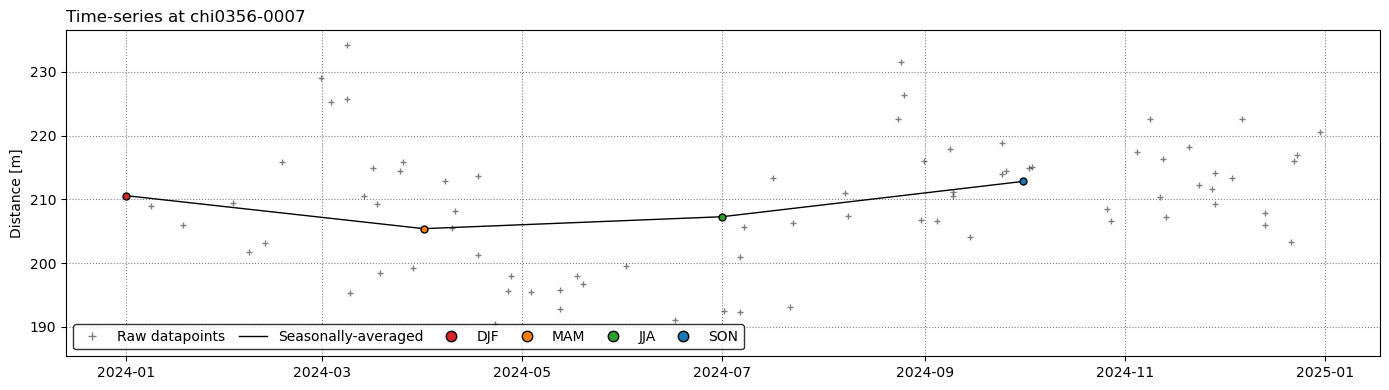

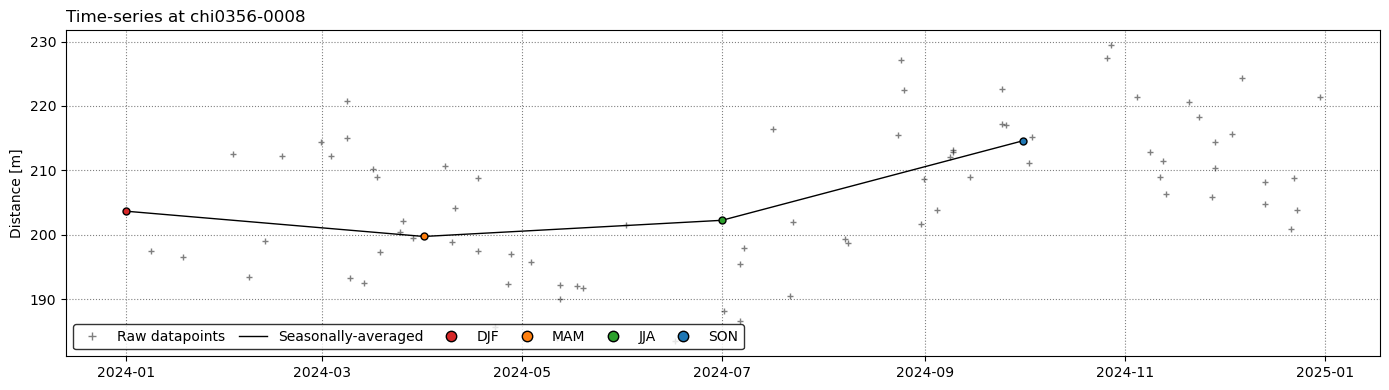

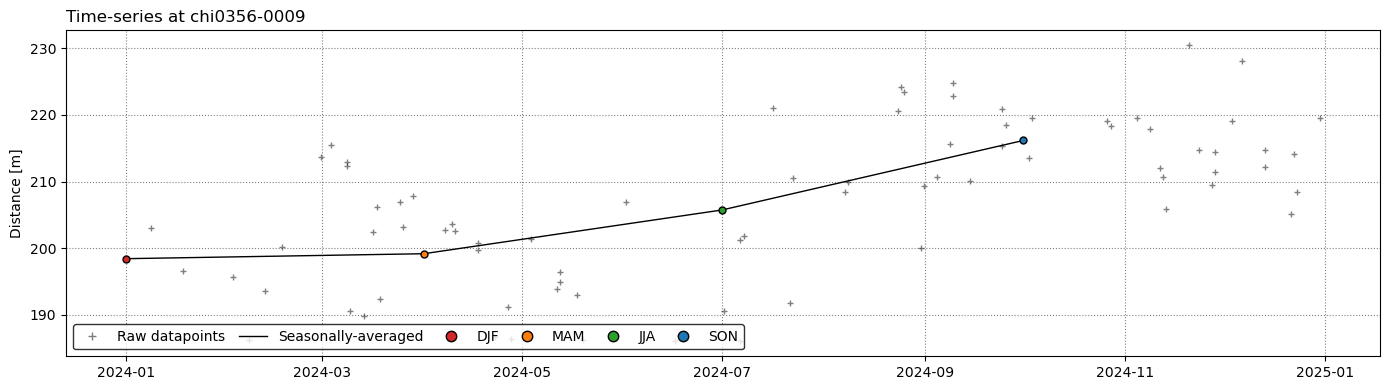

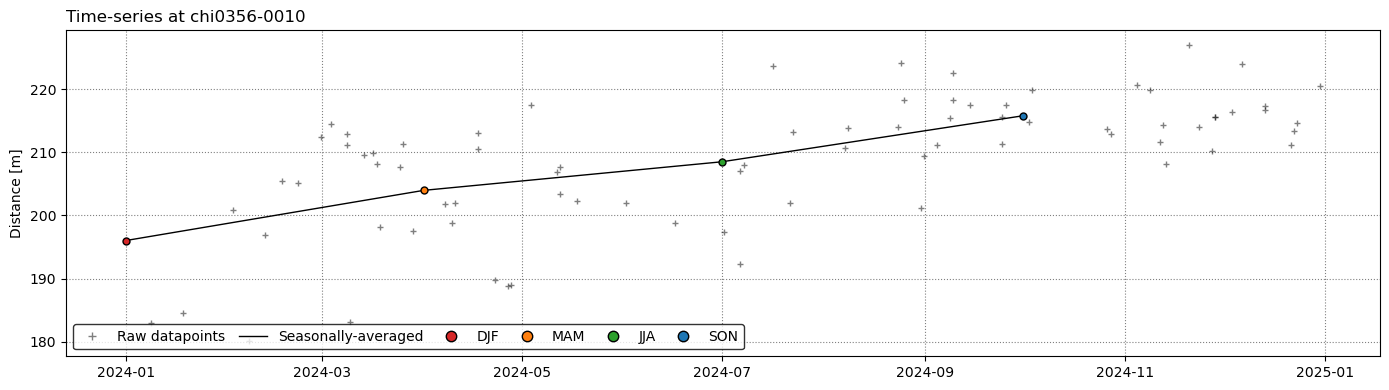

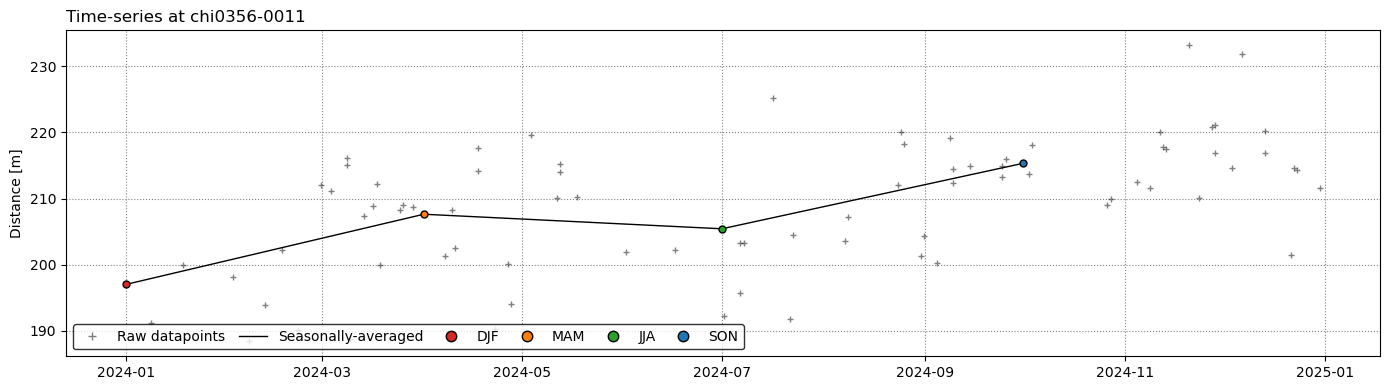

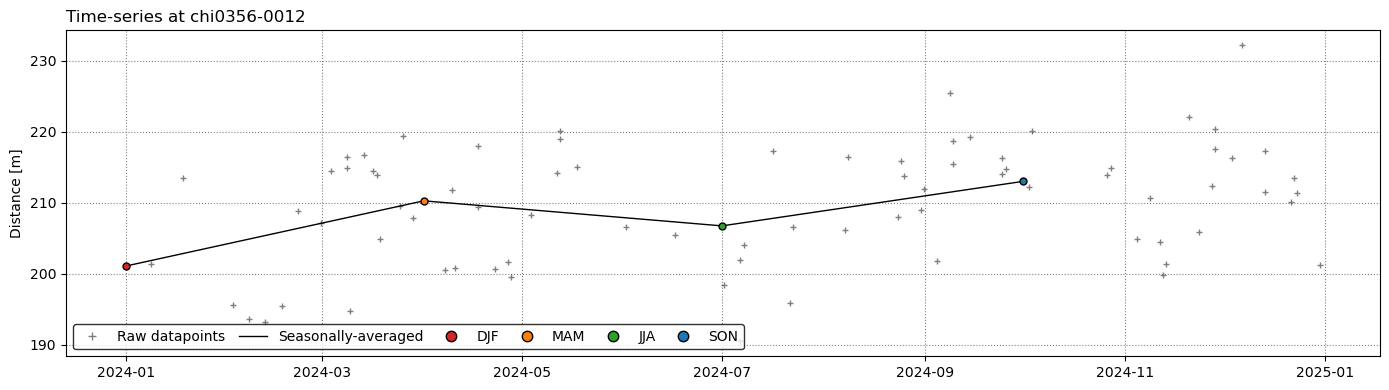

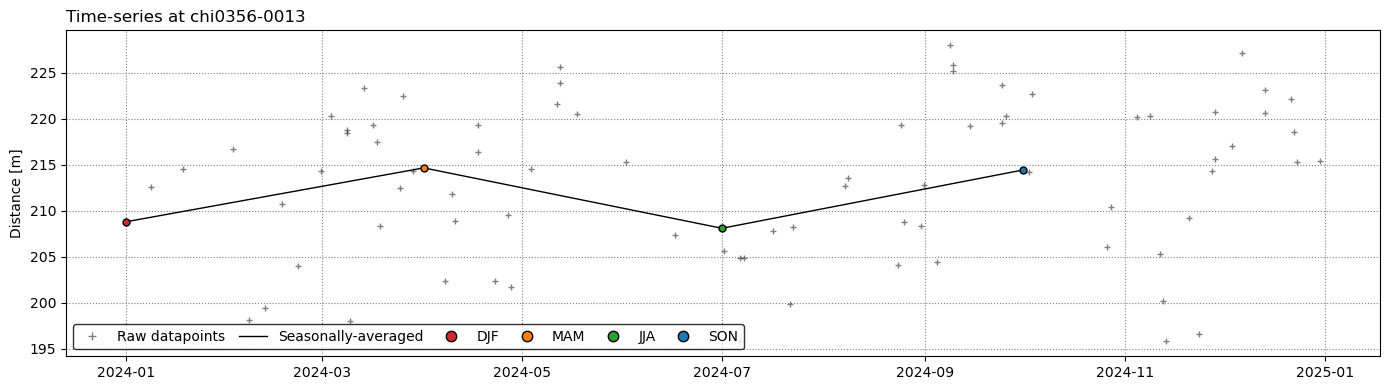

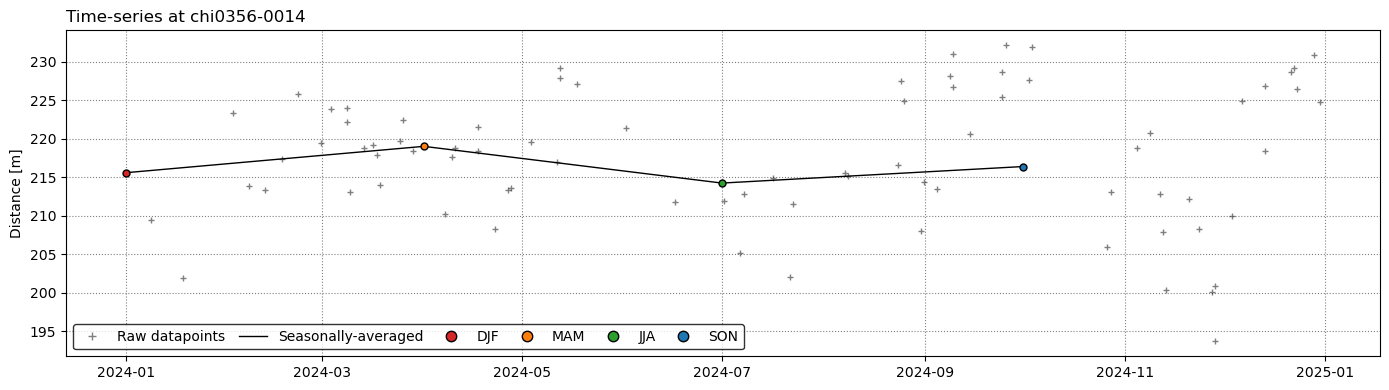

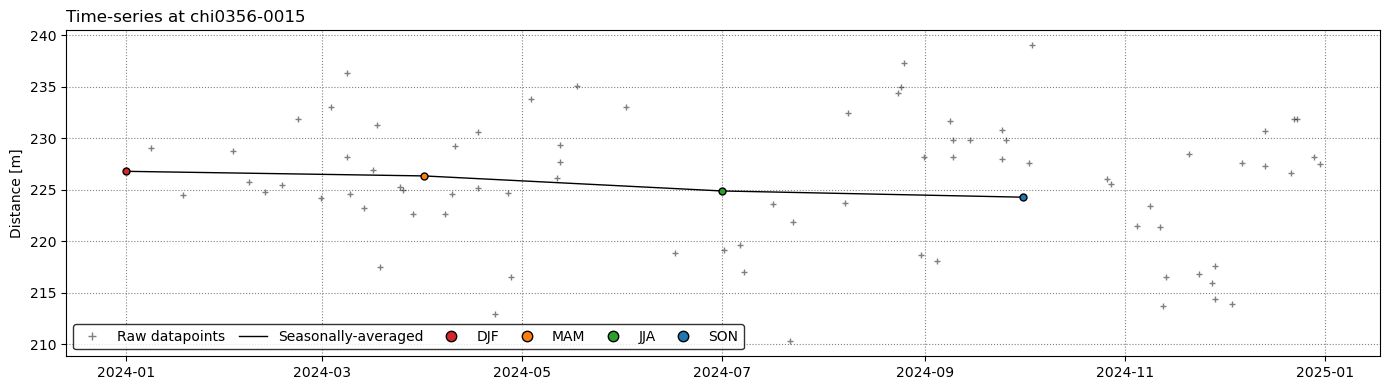

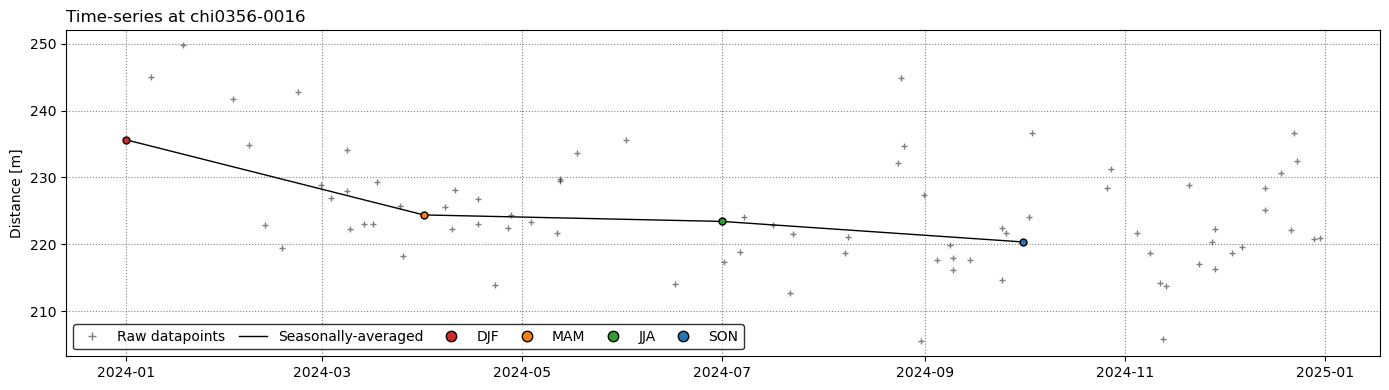

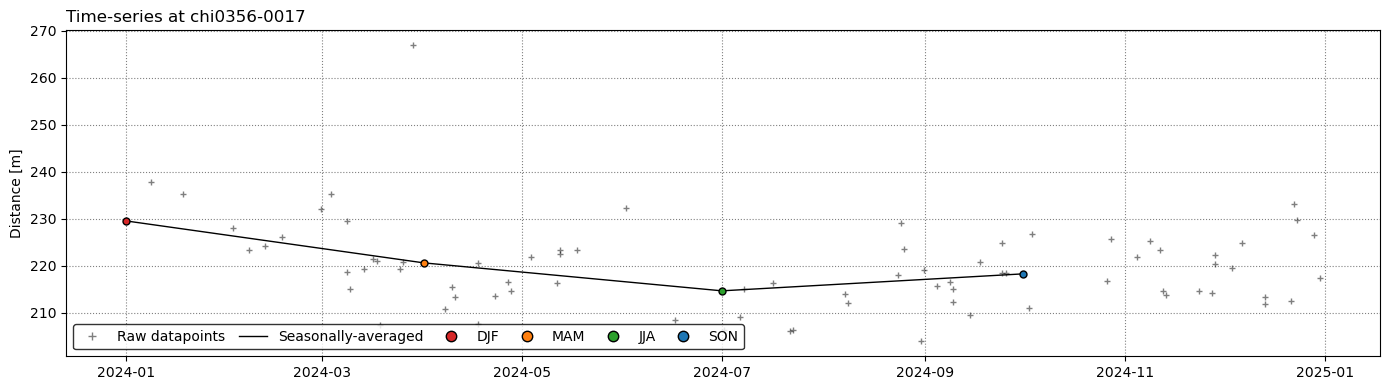

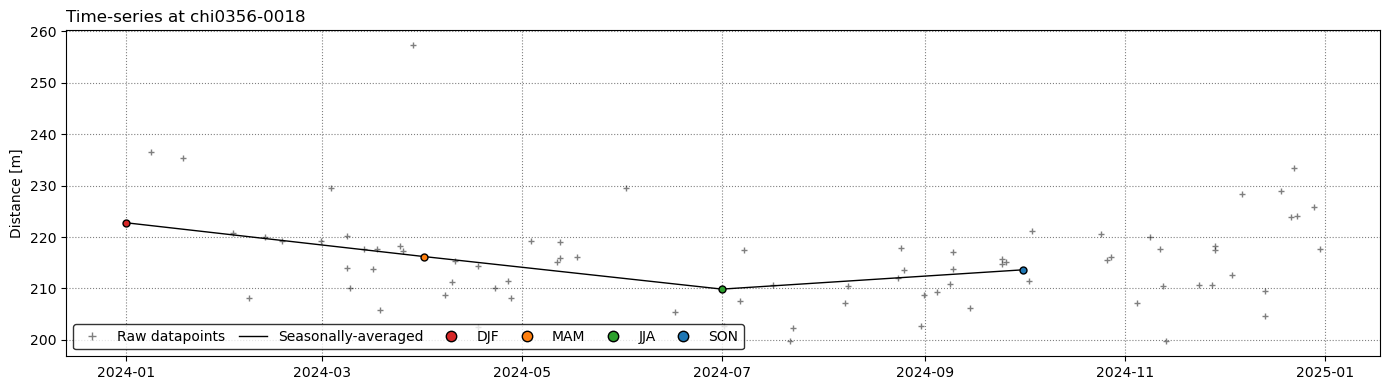

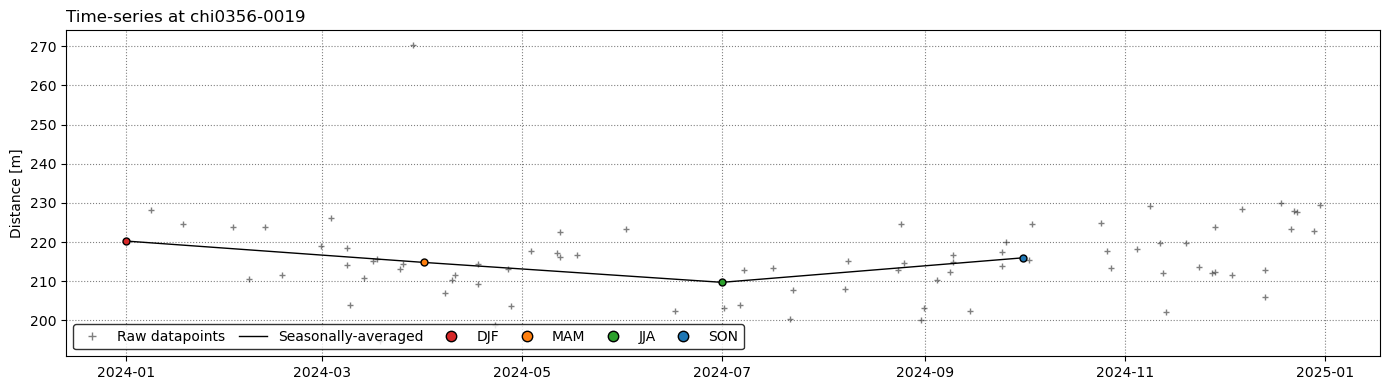

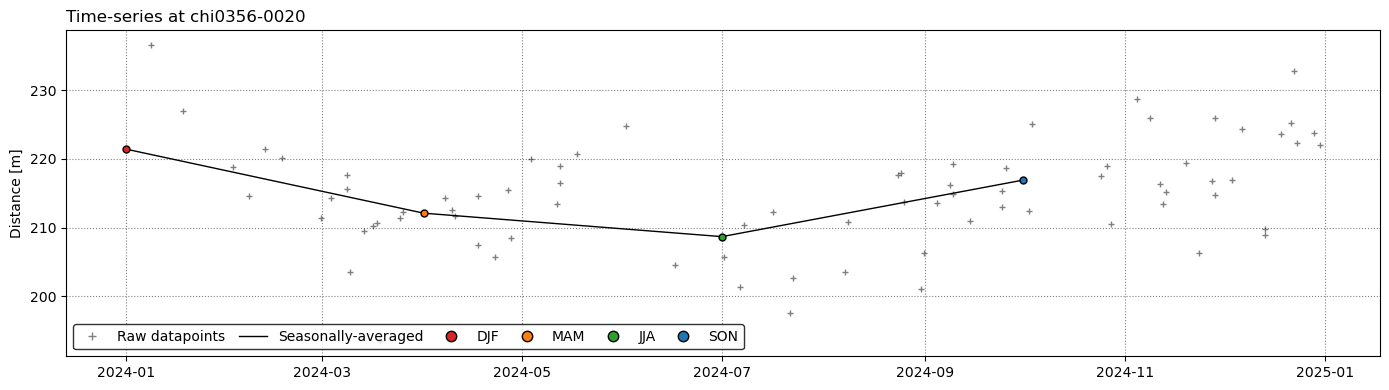

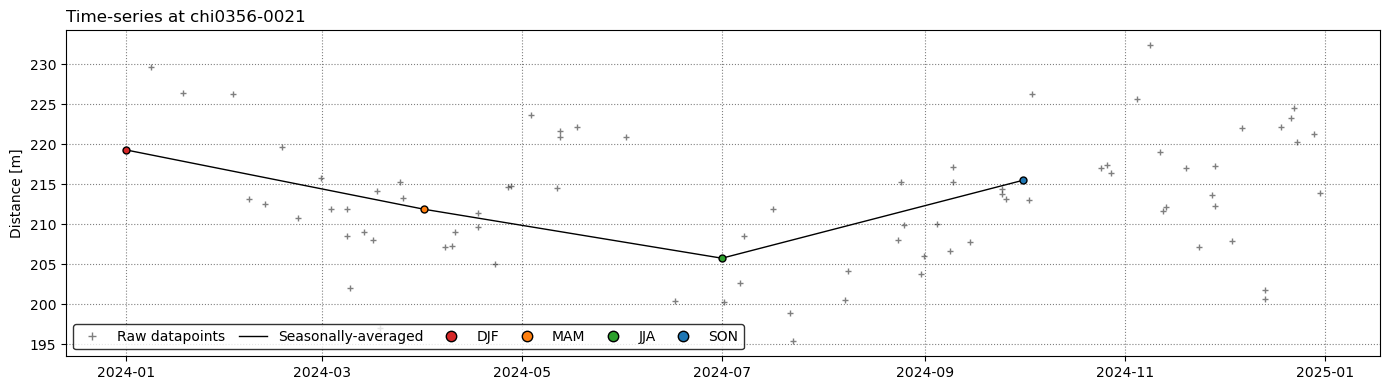

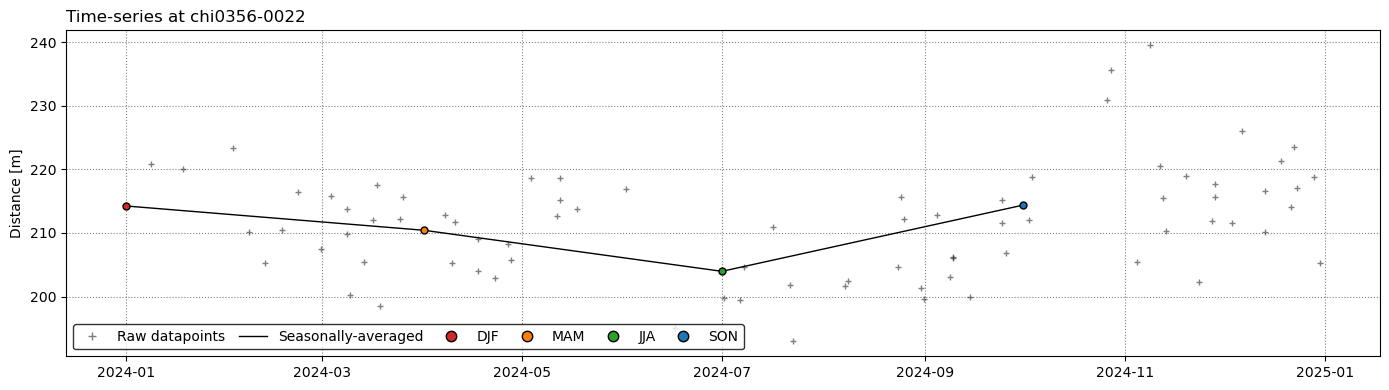

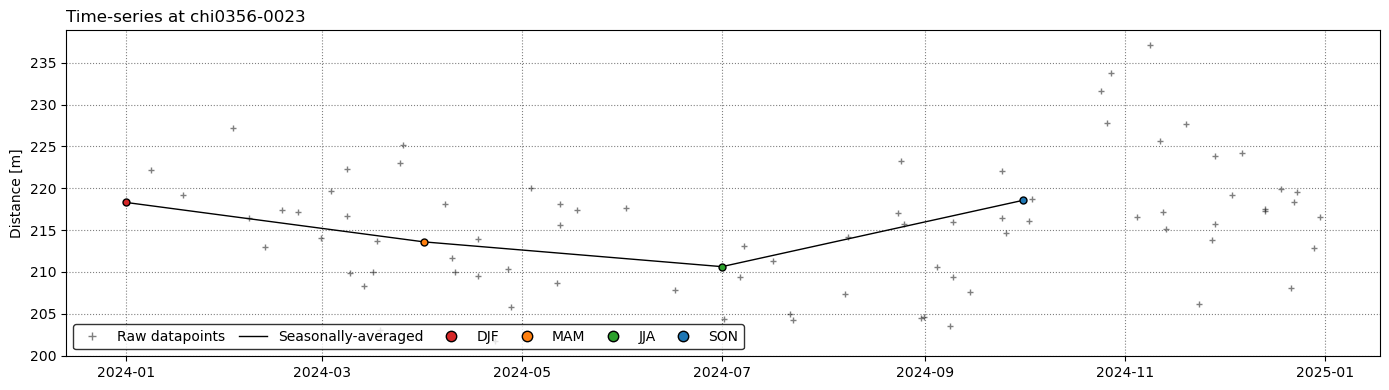

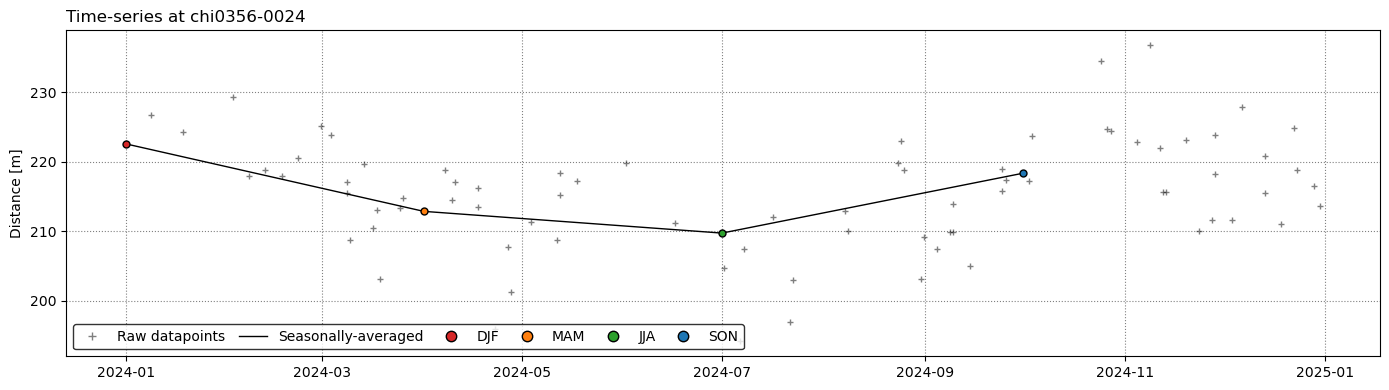

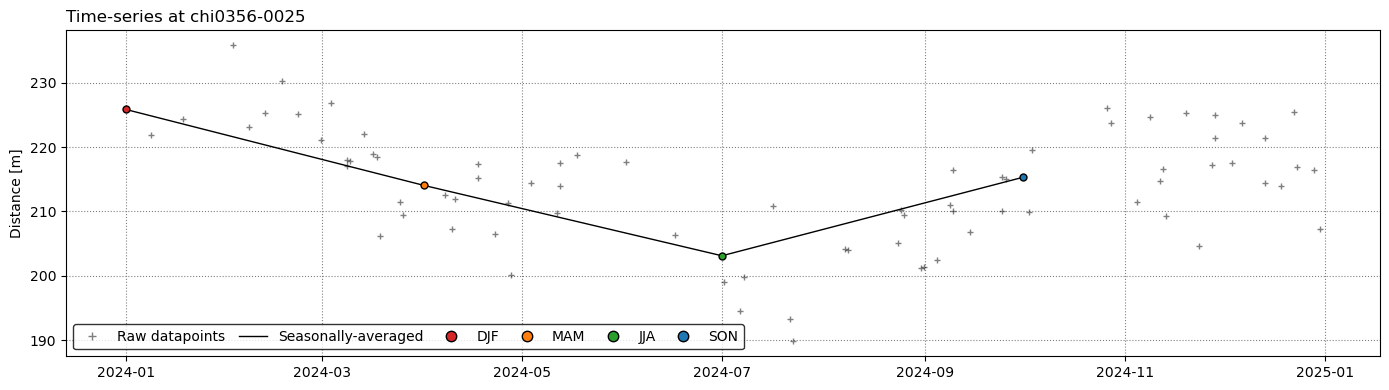

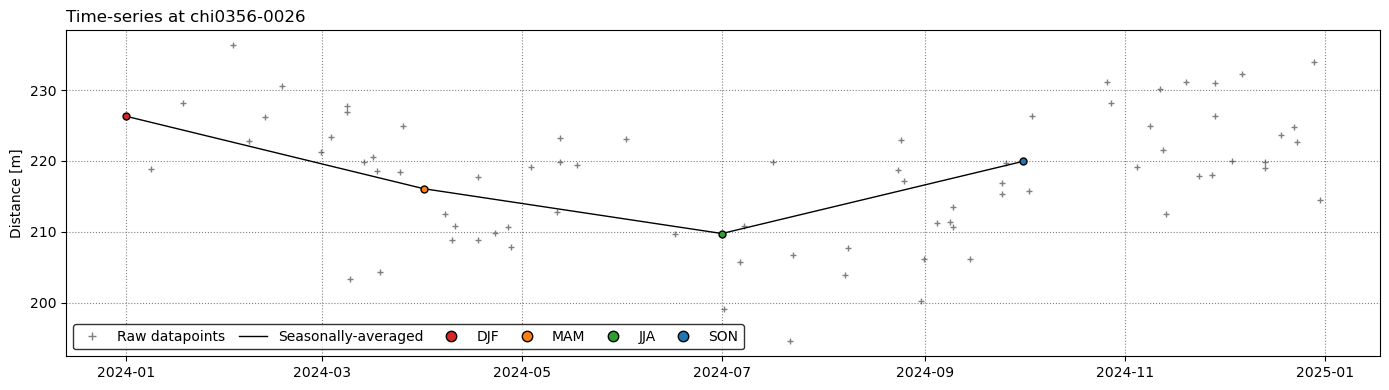

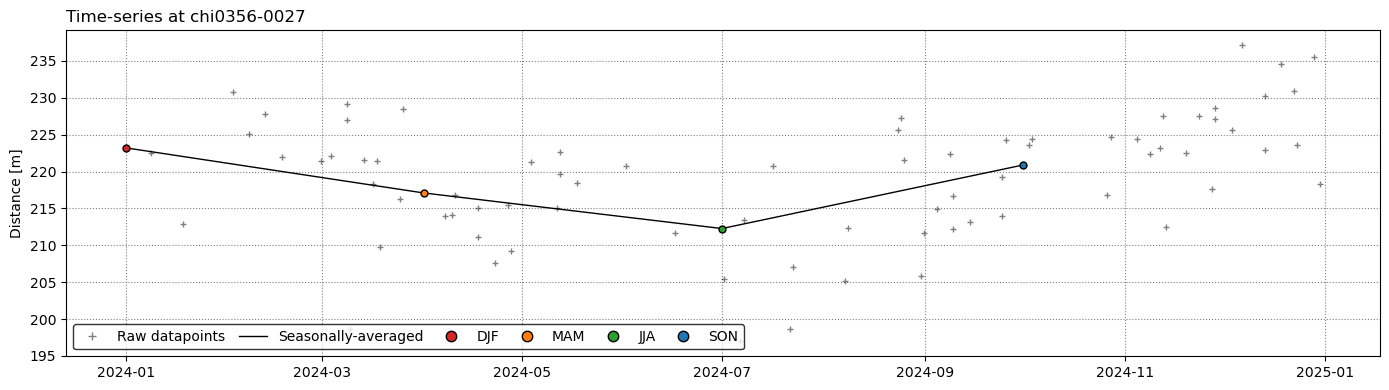

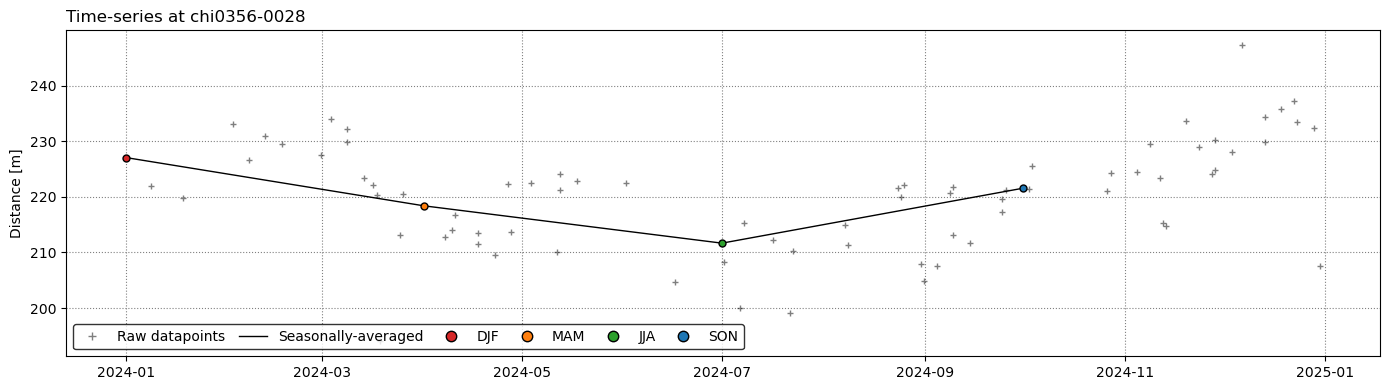

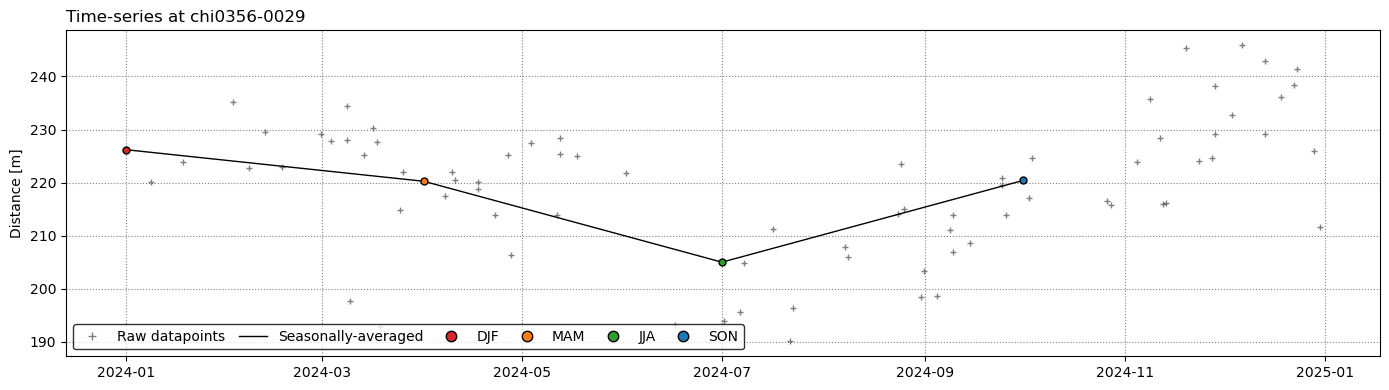

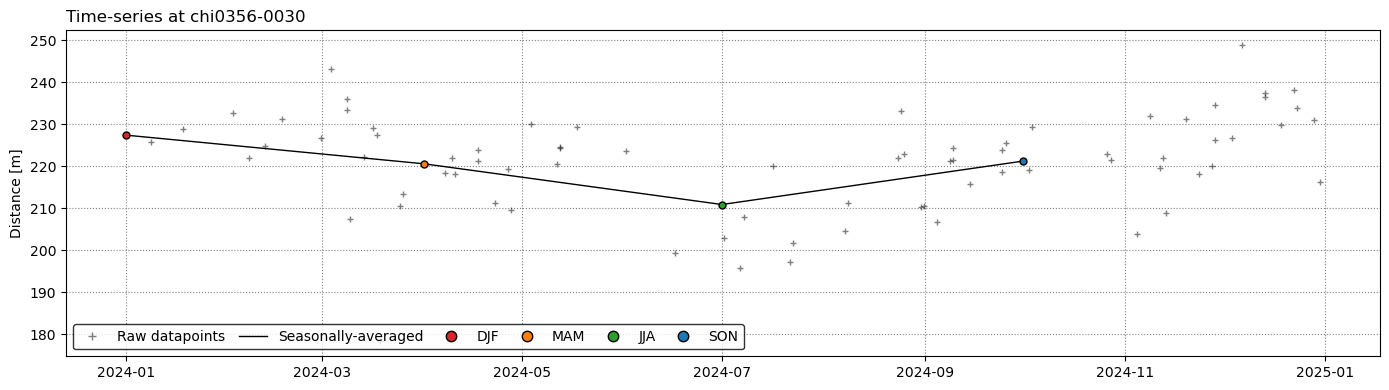

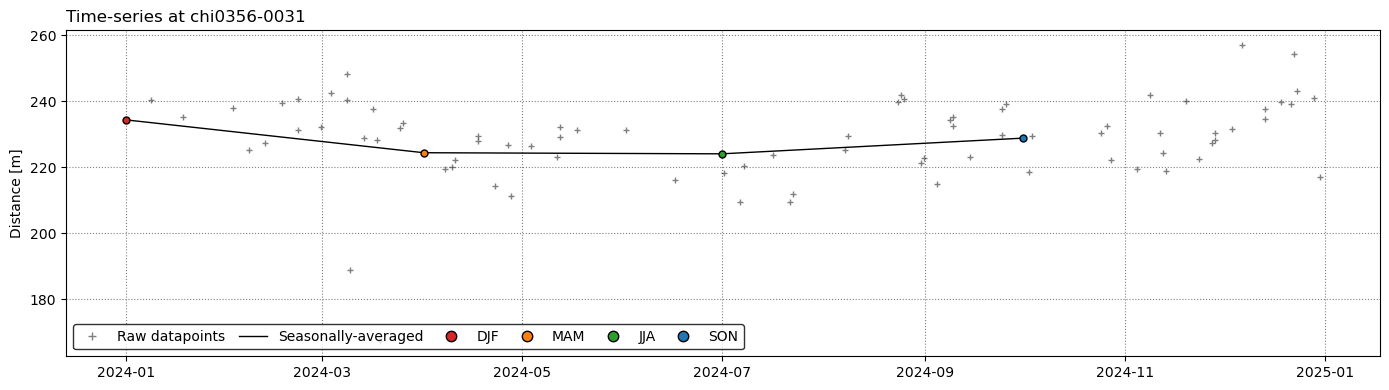

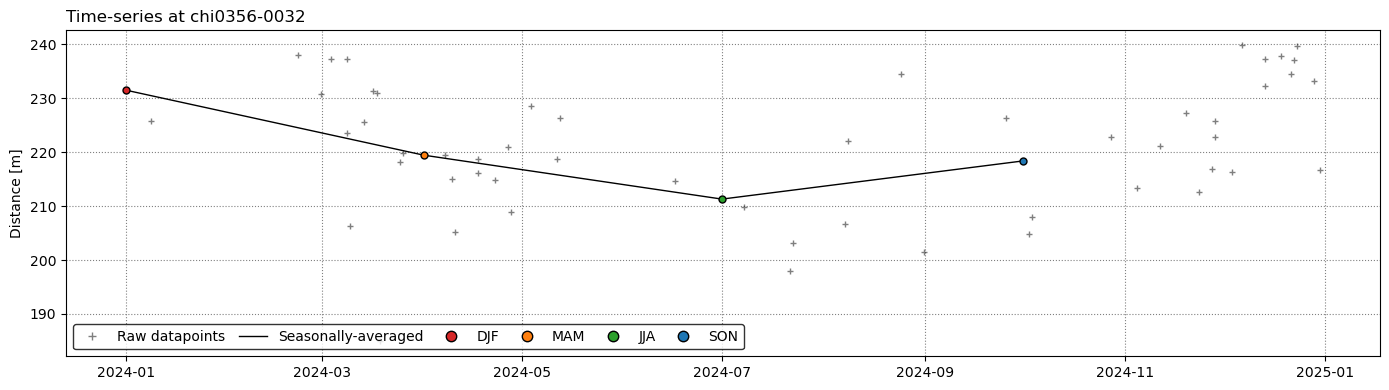

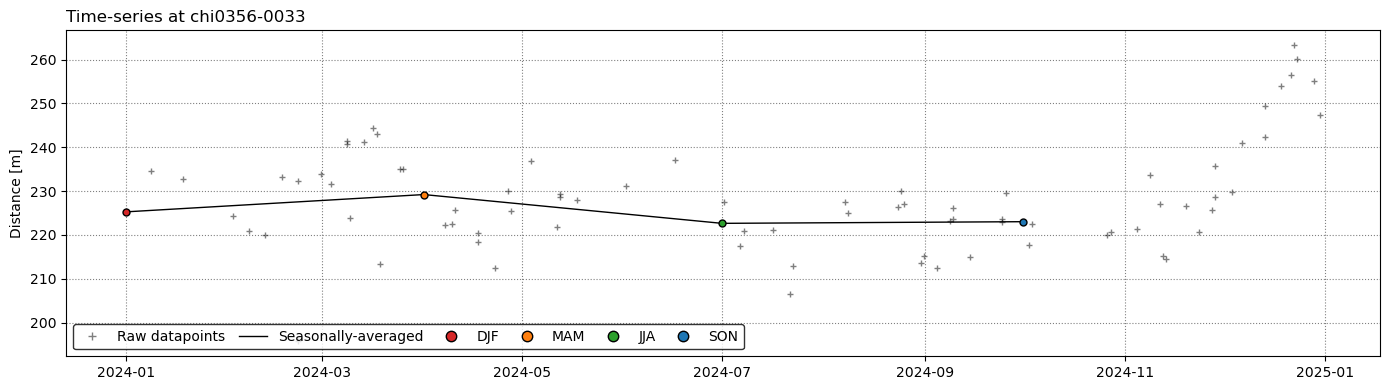

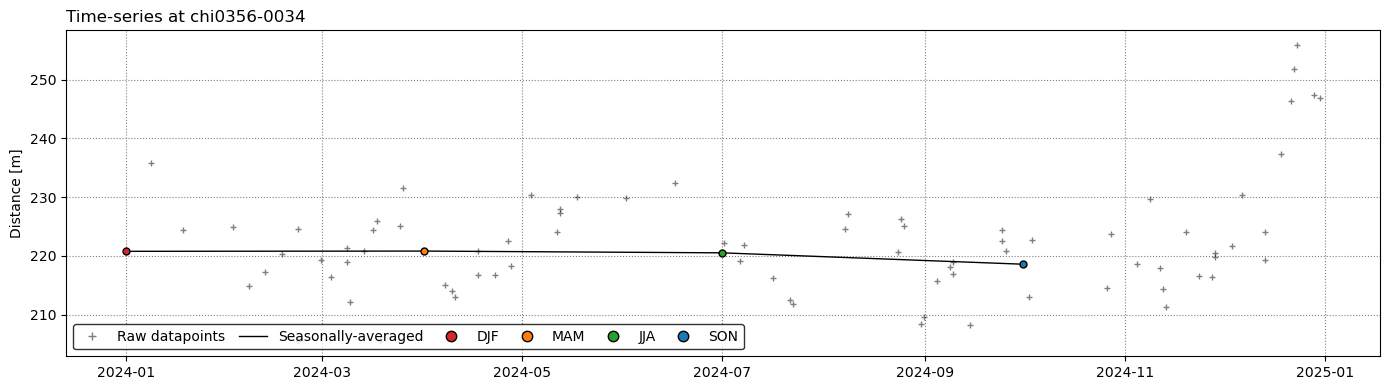

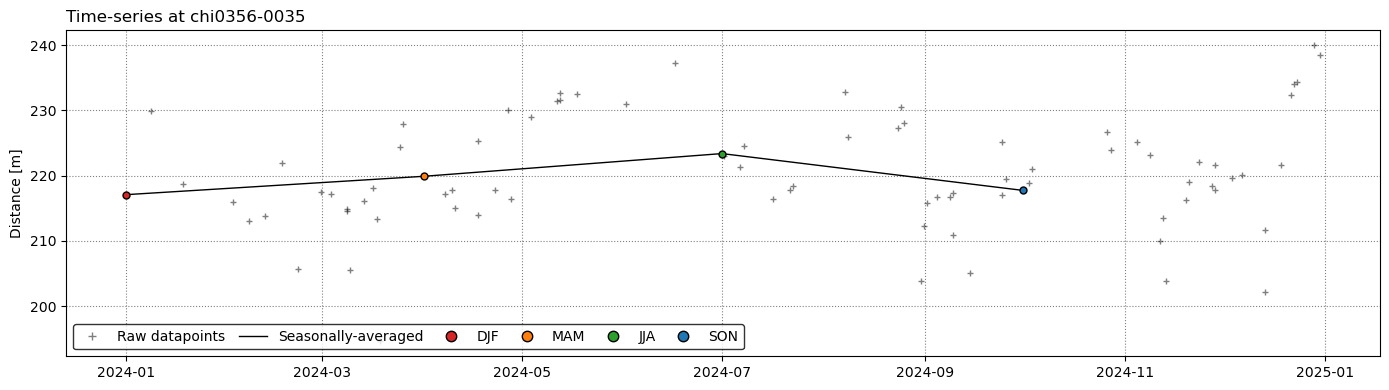

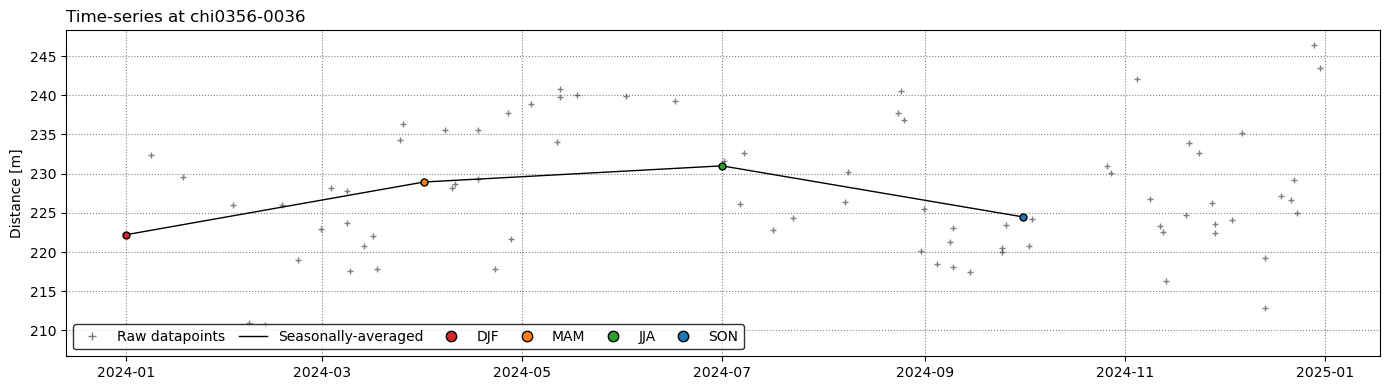

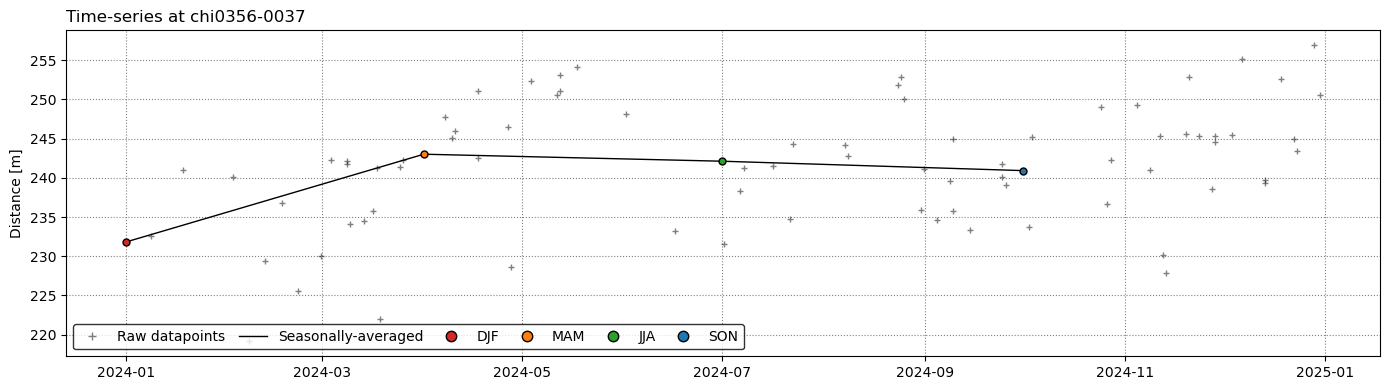

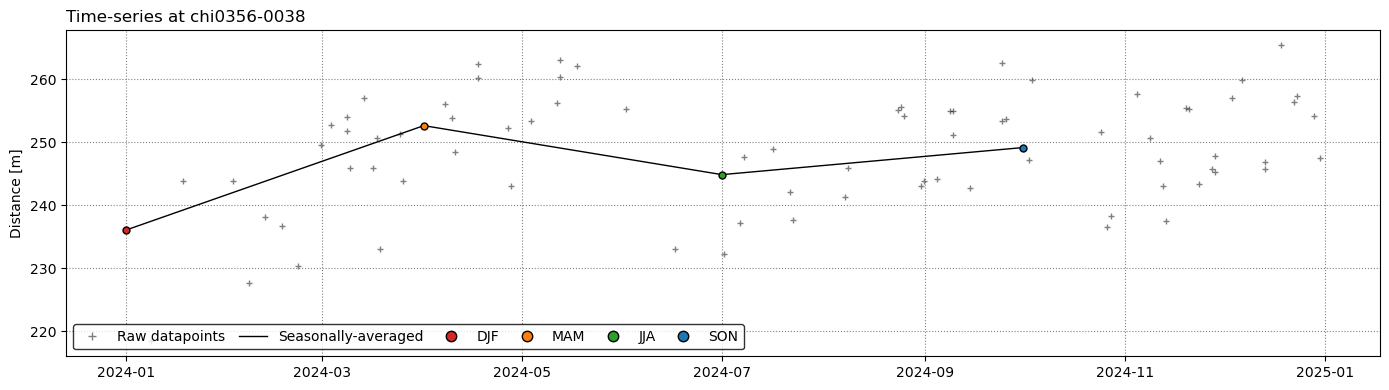

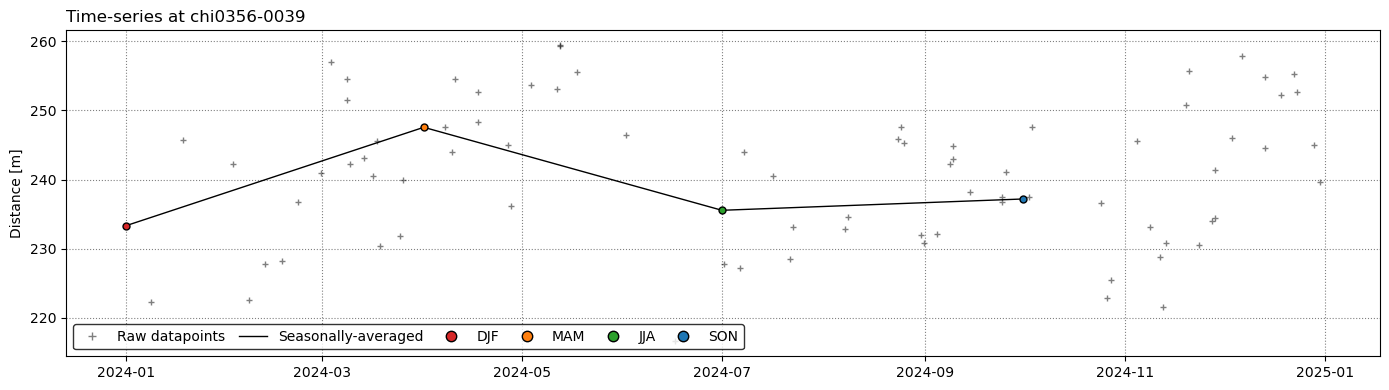

In [76]:
%matplotlib inline
# Definir colores para las estaciones
season_colors = {'DJF': 'C3', 'MAM': 'C1', 'JJA': 'C2', 'SON': 'C0'}

trending = []
estacionalidad = pd.DataFrame()

# Ruta para guardar resultados
output_dir = os.path.join(settings['inputs']['filepath'],
                          settings['inputs']['sitename'],
                          "Resultados",
                          "Transectos_Estacional")
os.makedirs(output_dir, exist_ok=True)  # Crear directorio si no existe

# Procesar cada transecto
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # Remover valores NaN
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan]

    # Calcular promedios estacionales (DJF, MAM, JJA, SON)
    dict_seas, dates_seas, chainage_seas, list_seas = SDS_transects.seasonal_average(dates_nonan, chainage)

    # Calcular tendencia a largo plazo
    trend, y = SDS_transects.calculate_trend(dates_seas, chainage_seas)

    # Crear gráfico de promedios estacionales
    fig, ax = plt.subplots(1, 1, figsize=[14, 4], tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title(f'Time-series at {key}', x=0, ha='left')
    ax.set(ylabel='Distance [m]')
    ax.plot(dates_nonan, chainage, '+', lw=1, color='k', mfc='w', ms=4, alpha=0.5, label='Raw datapoints')
    ax.plot(dates_seas, chainage_seas, '-', lw=1, color='k', mfc='w', ms=4, label='Seasonally-averaged')
    for k, seas in enumerate(dict_seas.keys()):
        ax.plot(
            dict_seas[seas]['dates'], dict_seas[seas]['chainages'],
            'o', mec='k', color=season_colors[seas], label=seas, ms=5
        )
    # ax.plot(dates_seas, y, '--', color='b', label=f'Trend {trend:.1f} m/year')
    ax.legend(loc='lower left', ncol=7, markerscale=1.5, frameon=True, edgecolor='k', columnspacing=1)

    # Guardar figura individual
    figure_path = os.path.join(output_dir, f"seasonality_{key}.png")
    plt.savefig(figure_path, dpi=300)
    print(f"Figura de estacionalidad guardada en: {figure_path}")

    # Agregar datos a las listas
    trending.append(trend)
    estacionalidad[key] = dict_seas

# Crear DataFrame para tendencias y guardar como CSV
tendencia = pd.DataFrame({
    'seccion': list(cross_distance.keys()),
    'tendencia': trending
})

tendencia_csv_path = os.path.join(output_dir, "tendencias.csv")
tendencia.to_csv(tendencia_csv_path, index=False)
print(f"Tendencias guardadas en: {tendencia_csv_path}")


In [77]:
#Estudio por estación
print(estacionalidad)

                                          chi0356-0000  \
DJF  {'dates': [2024-01-01 00:00:00+00:00], 'chaina...   
MAM  {'dates': [2024-04-01 00:00:00+00:00], 'chaina...   
JJA  {'dates': [2024-07-01 00:00:00+00:00], 'chaina...   
SON  {'dates': [2024-10-01 00:00:00+00:00], 'chaina...   

                                          chi0356-0001  \
DJF  {'dates': [2024-01-01 00:00:00+00:00], 'chaina...   
MAM  {'dates': [2024-04-01 00:00:00+00:00], 'chaina...   
JJA  {'dates': [2024-07-01 00:00:00+00:00], 'chaina...   
SON  {'dates': [2024-10-01 00:00:00+00:00], 'chaina...   

                                          chi0356-0002  \
DJF  {'dates': [2024-01-01 00:00:00+00:00], 'chaina...   
MAM  {'dates': [2024-04-01 00:00:00+00:00], 'chaina...   
JJA  {'dates': [2024-07-01 00:00:00+00:00], 'chaina...   
SON  {'dates': [2024-10-01 00:00:00+00:00], 'chaina...   

                                          chi0356-0003  \
DJF  {'dates': [2024-01-01 00:00:00+00:00], 'chaina...   
MAM  {'date

Exportamos la tendencia de la playa, junto con los valores estacionales.

In [78]:
#Exportamos archivos con tendendias y estacionalidad
dn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'trend_series_tidally_corrected.csv')
tendencia.to_csv(dn, sep=',')
print('Trend of tidally-corrected time-series saved as:\n%s'%dn)

rn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'season_time_series.csv')
estacionalidad.to_csv(rn, sep=',')
print('Season of tidally-corrected time-series saved as:\n%s'%dn)

Trend of tidally-corrected time-series saved as:
d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\trend_series_tidally_corrected.csv
Season of tidally-corrected time-series saved as:
d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\trend_series_tidally_corrected.csv


#### 5.3 Monthly averages

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.monthly_average()` and plot them.

Figura de promedios mensuales guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Mensual\monthly_chi0356-0000.png
Figura de promedios mensuales guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Mensual\monthly_chi0356-0001.png
Figura de promedios mensuales guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Mensual\monthly_chi0356-0002.png
Figura de promedios mensuales guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Mensual\monthly_chi0356-0003.png
Figura de promedios mensuales guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Mensual\monthly_chi0356-0004.png
Figura de promedios mensuales guardada en: d:\Rafael Rencoret\SIMONA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\Resultados\Transectos_Mensual\monthly_chi0356-0005.png
Figura de promedios me

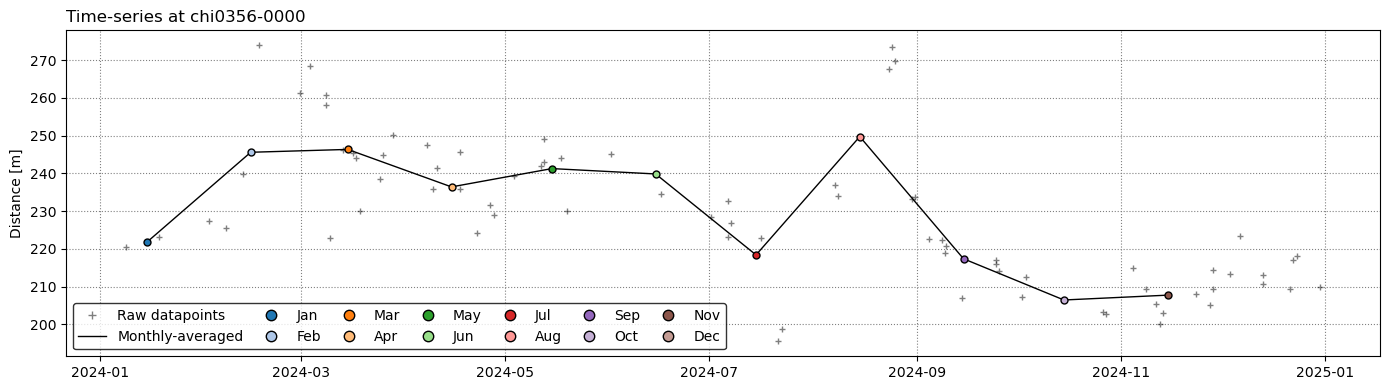

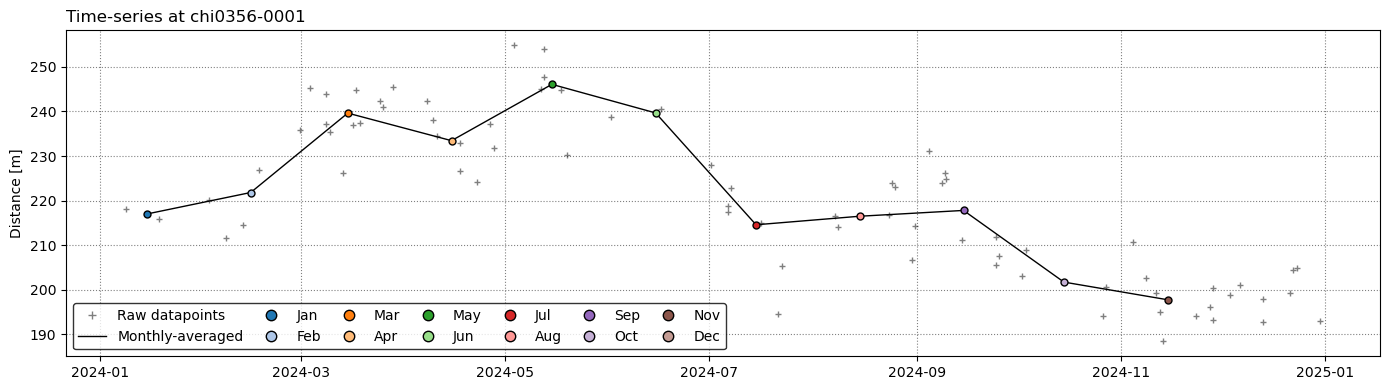

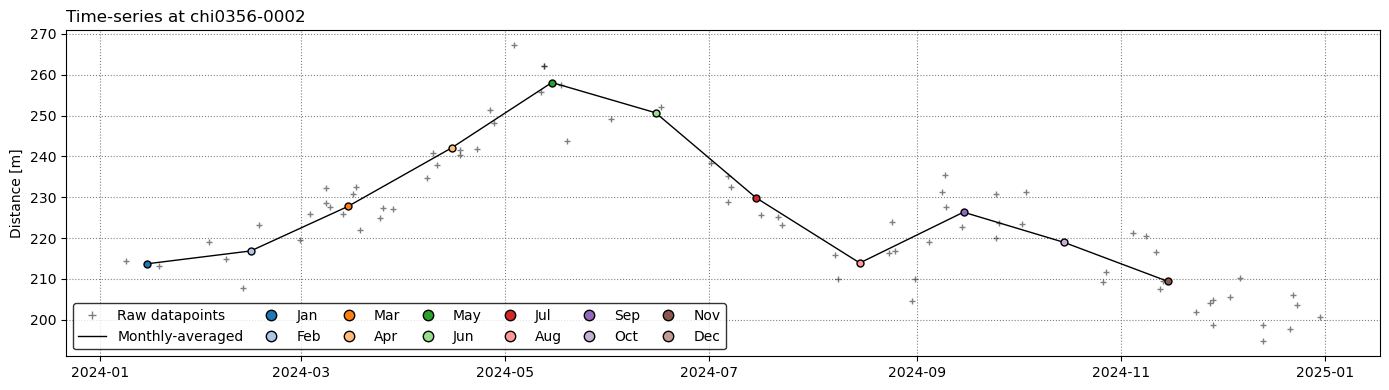

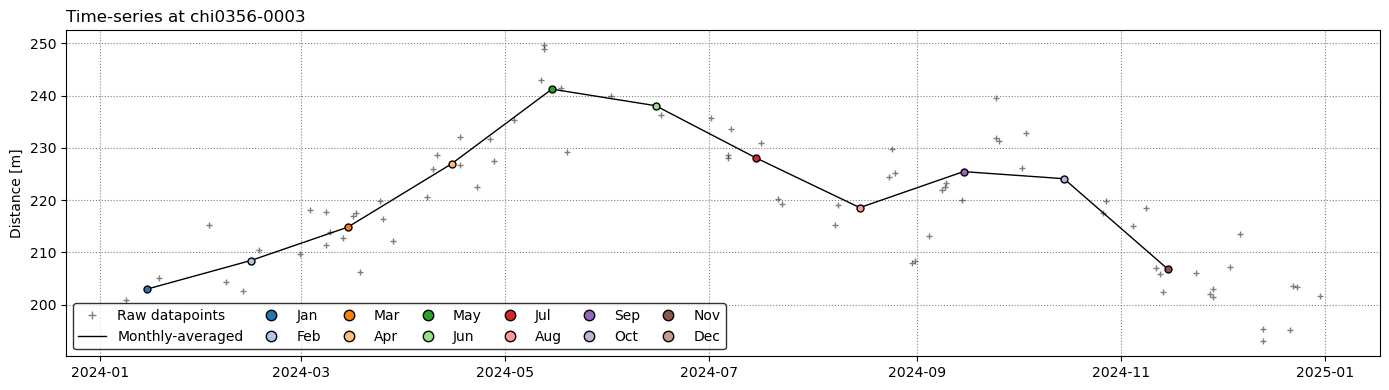

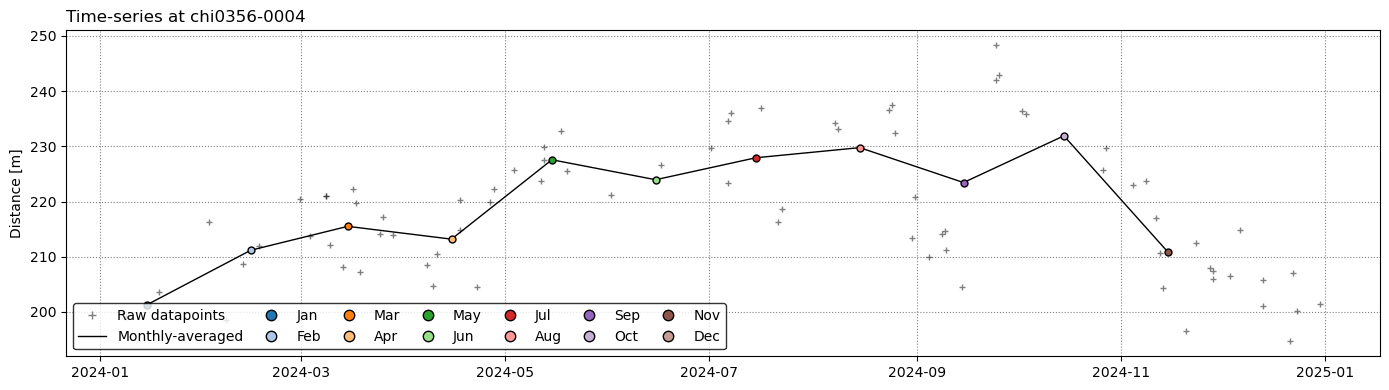

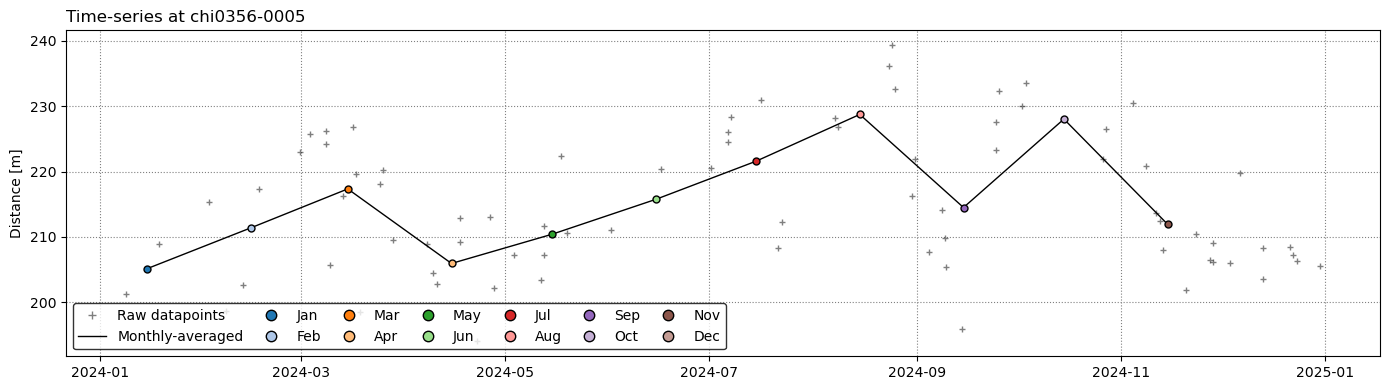

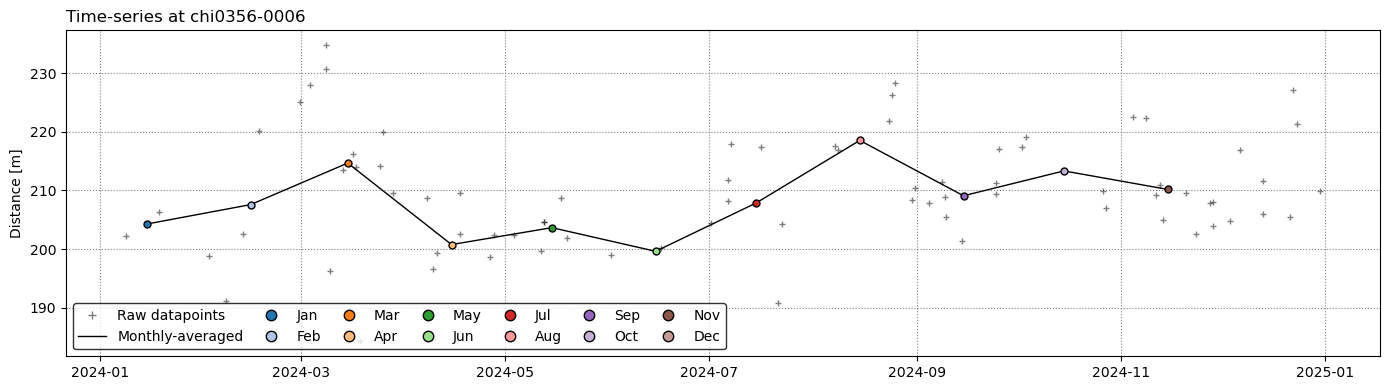

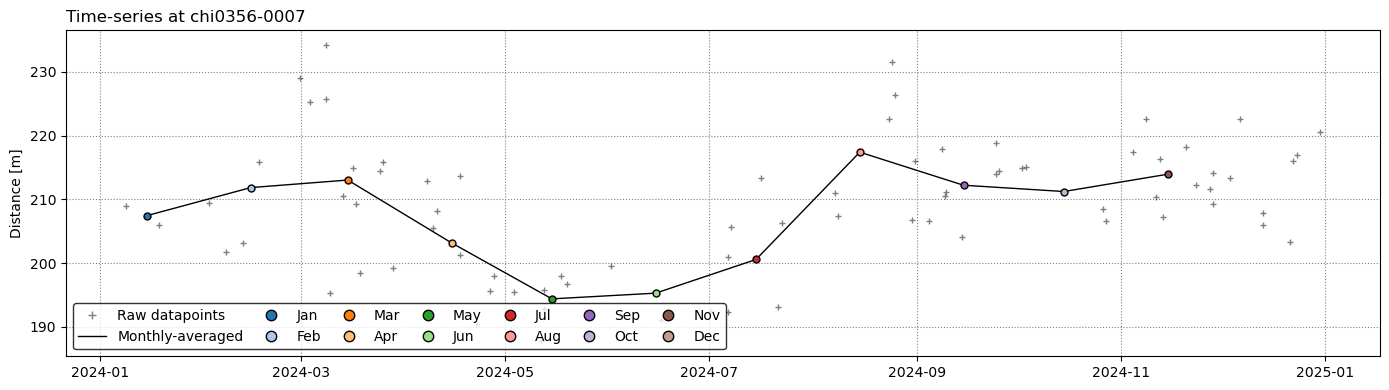

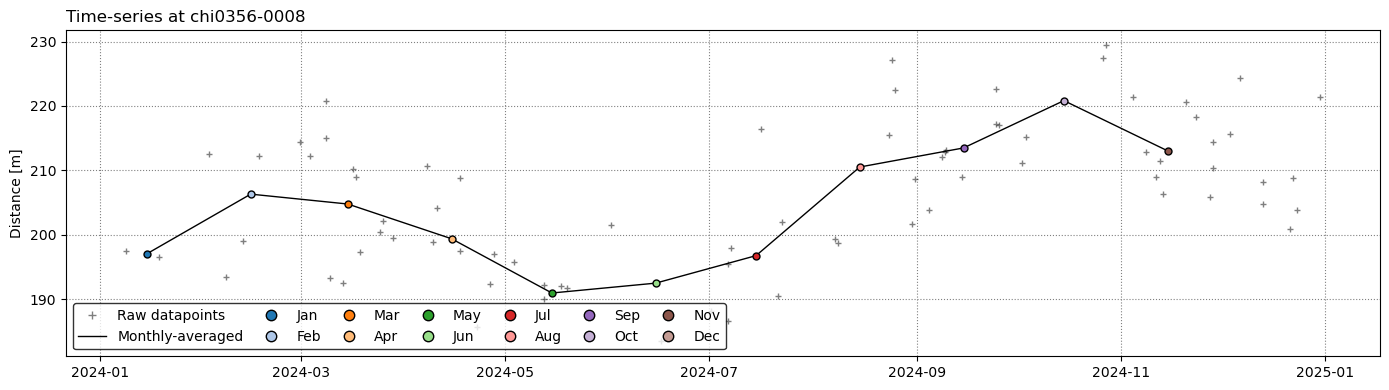

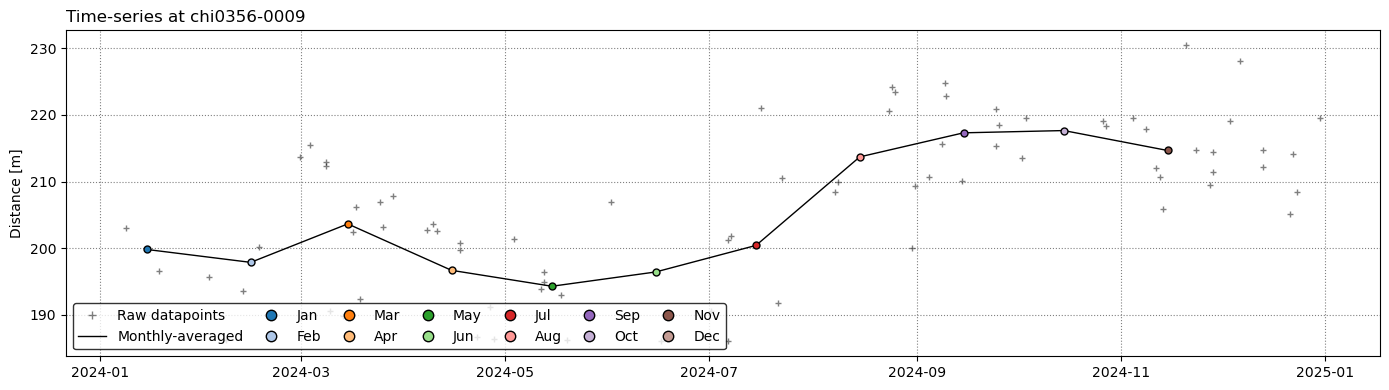

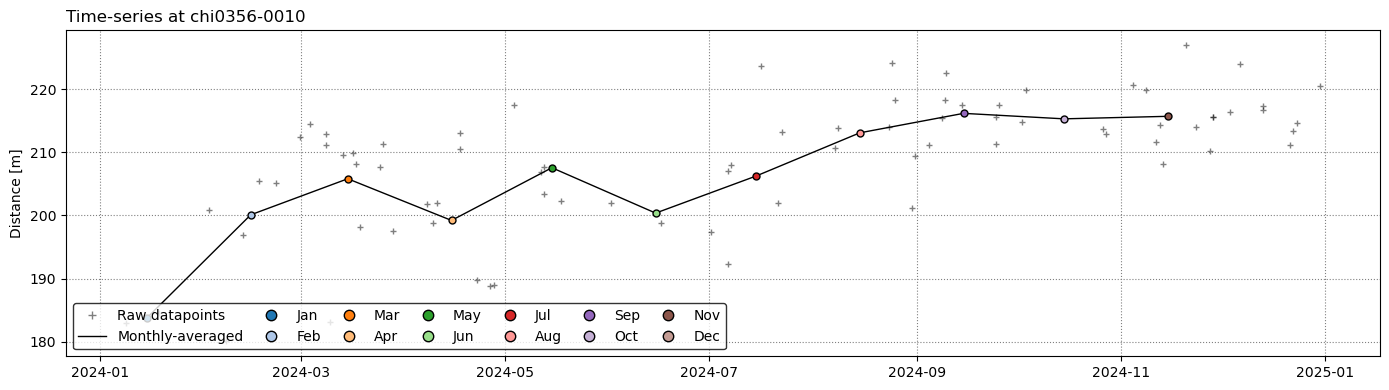

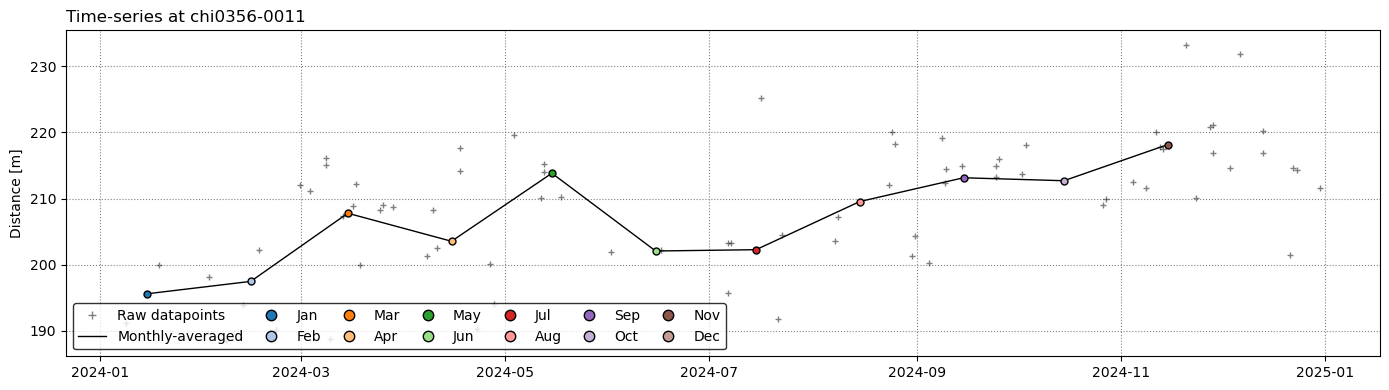

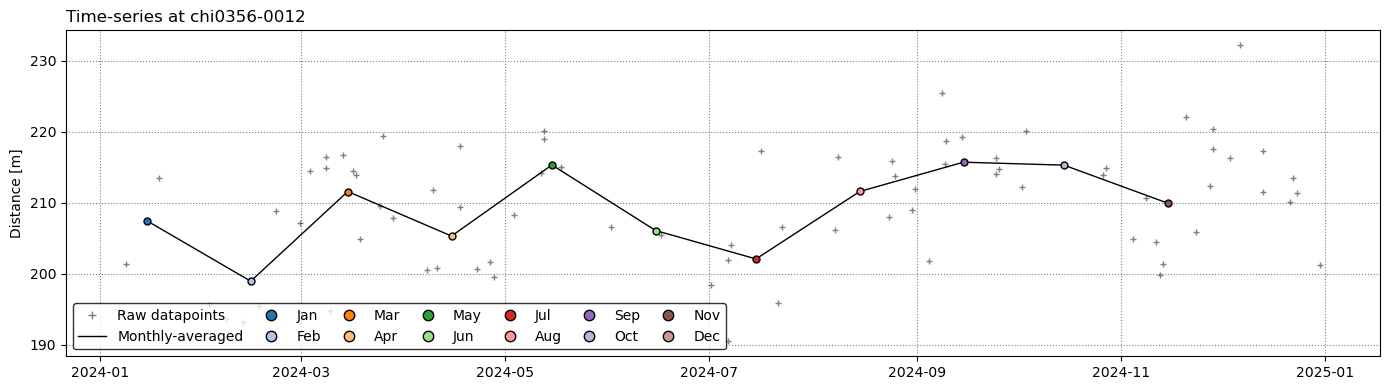

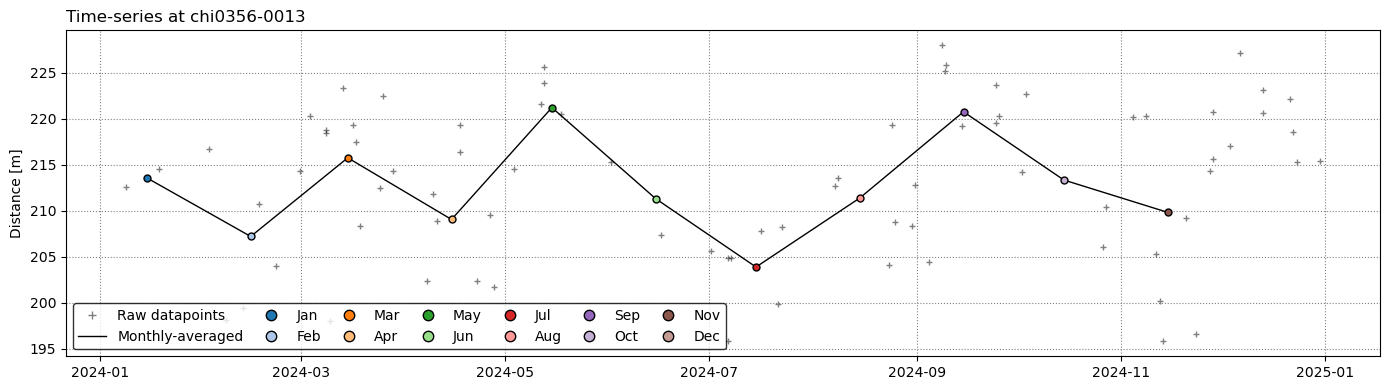

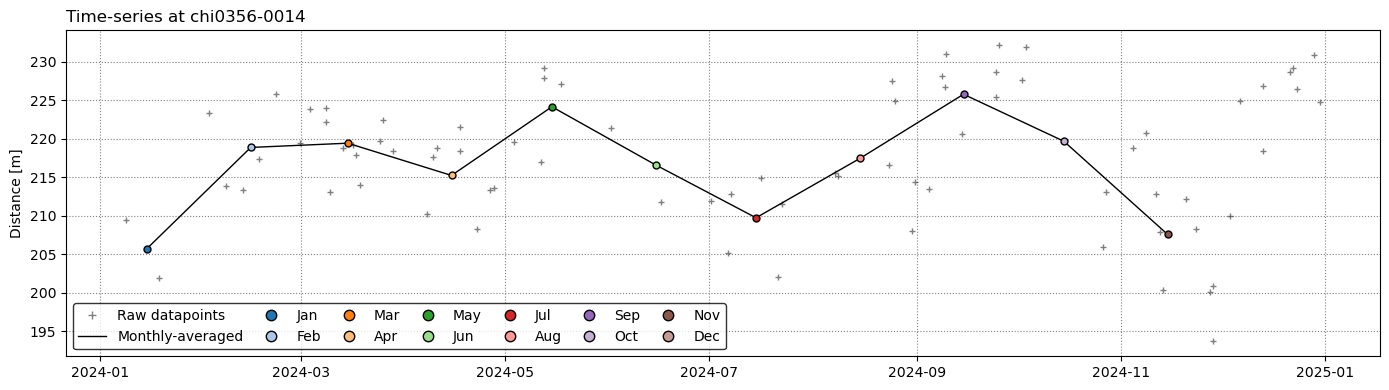

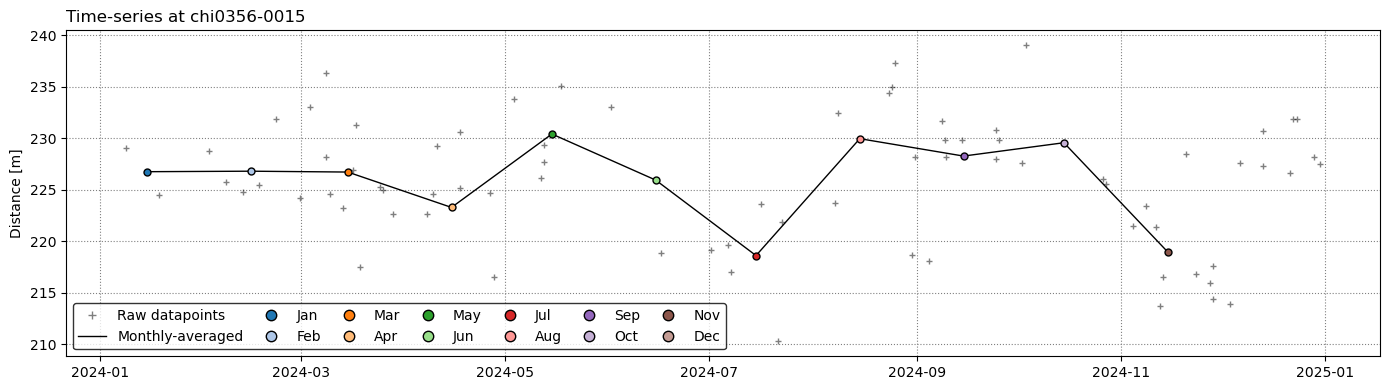

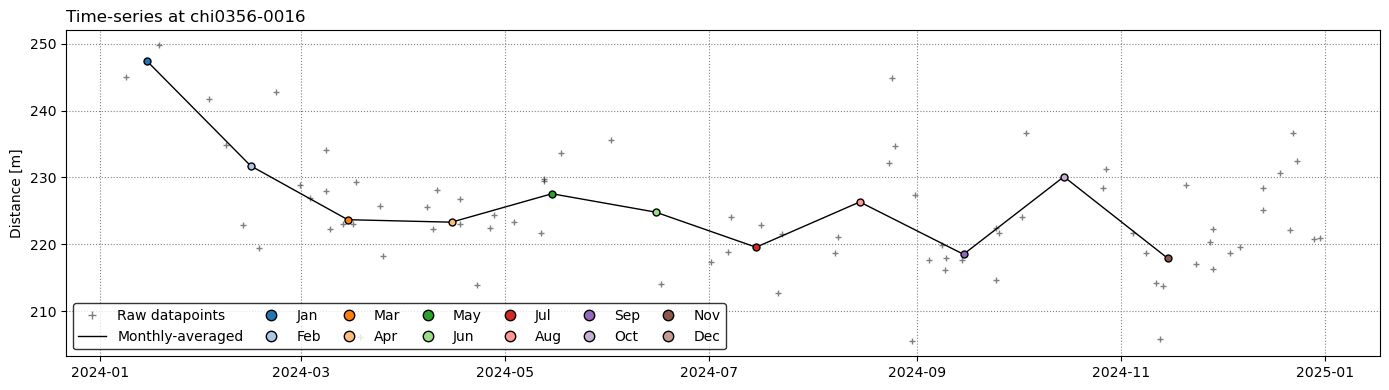

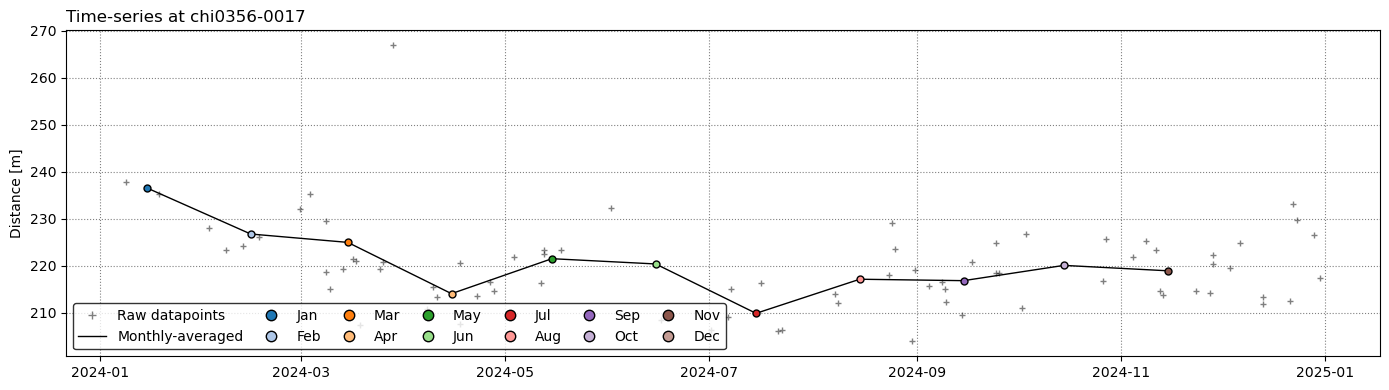

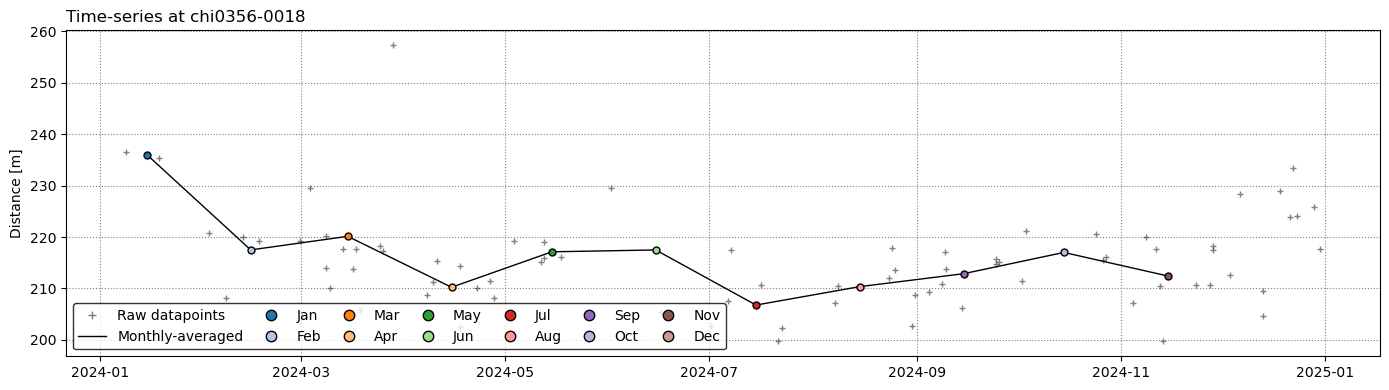

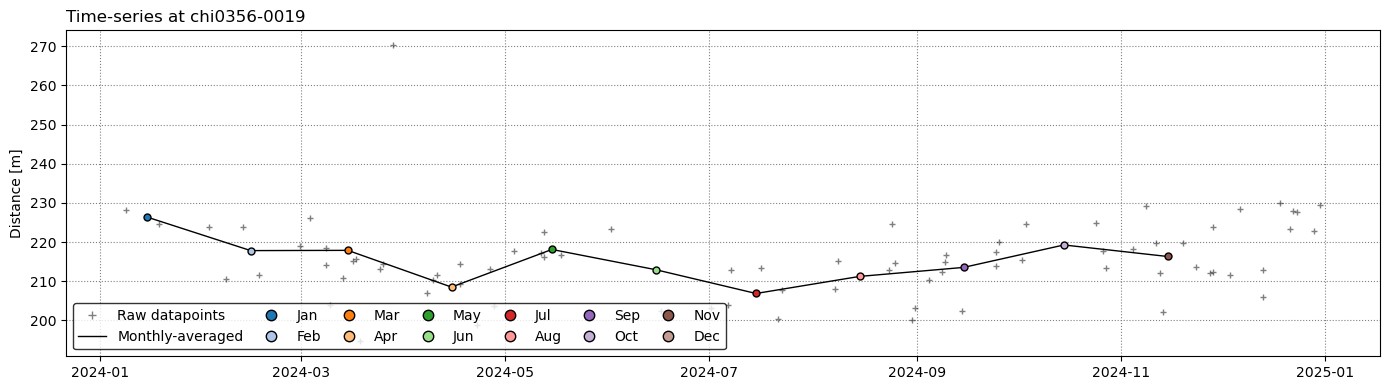

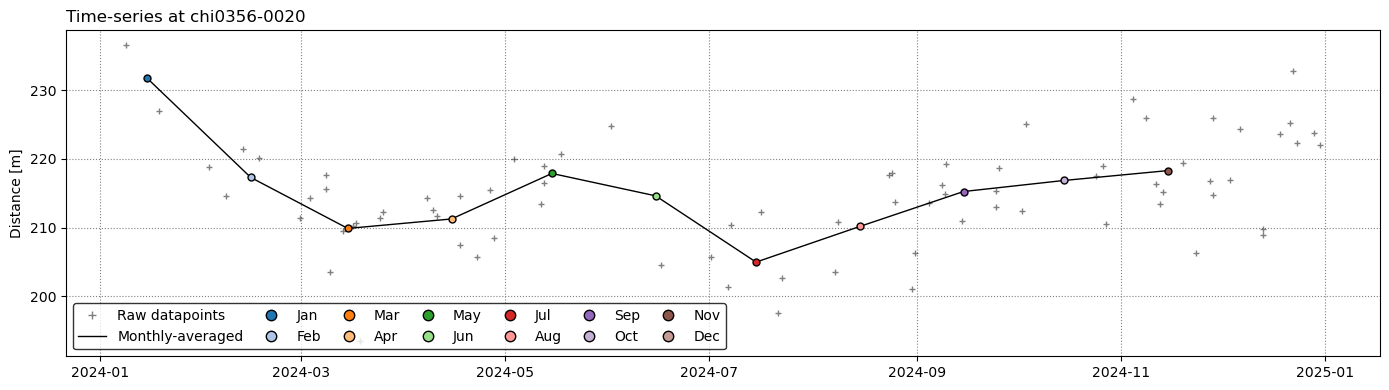

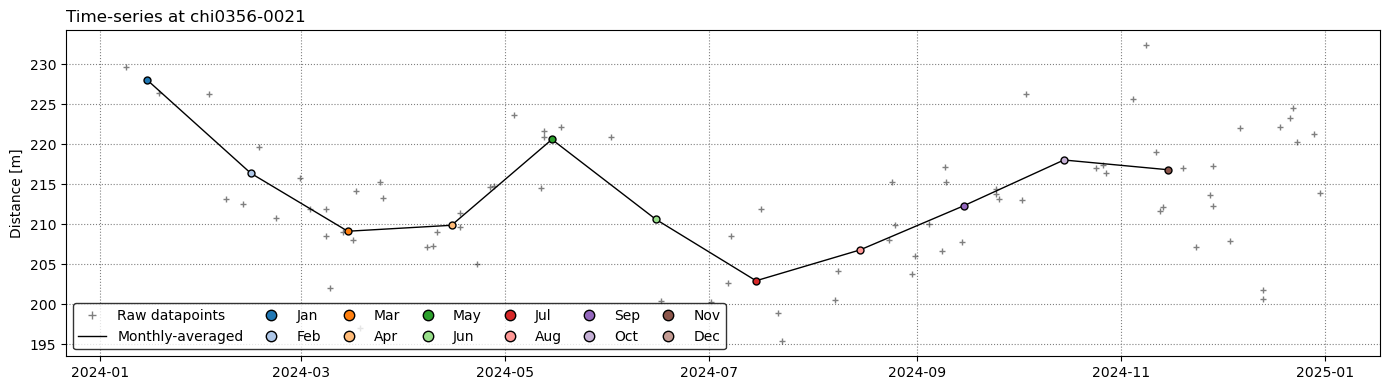

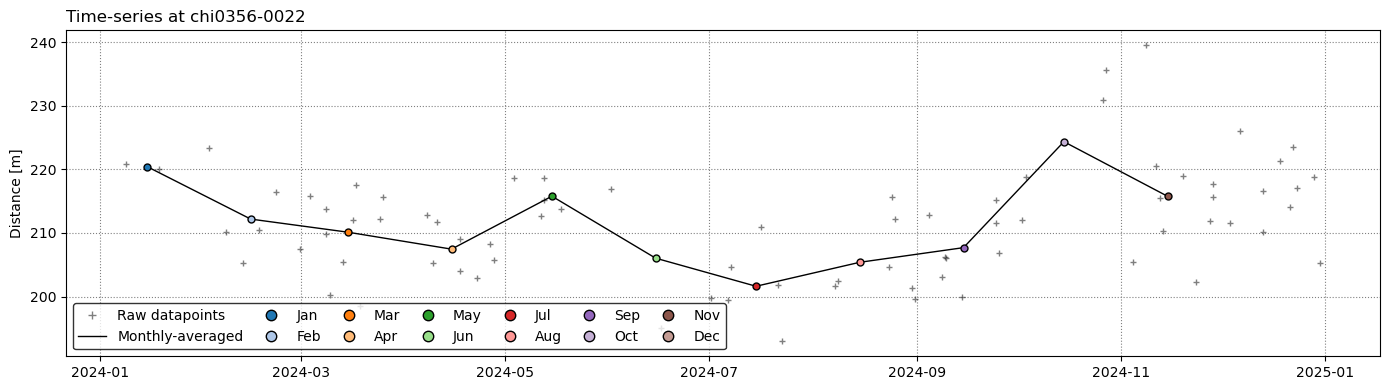

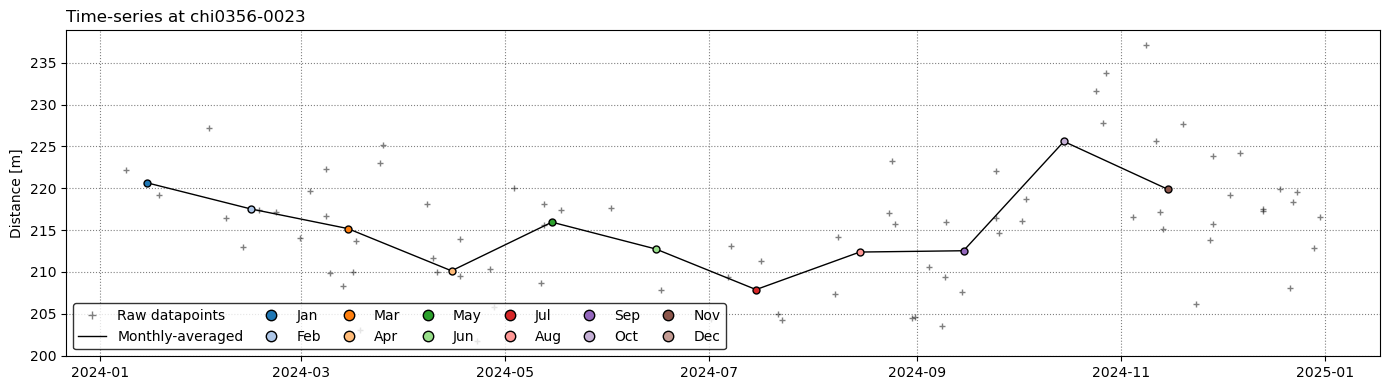

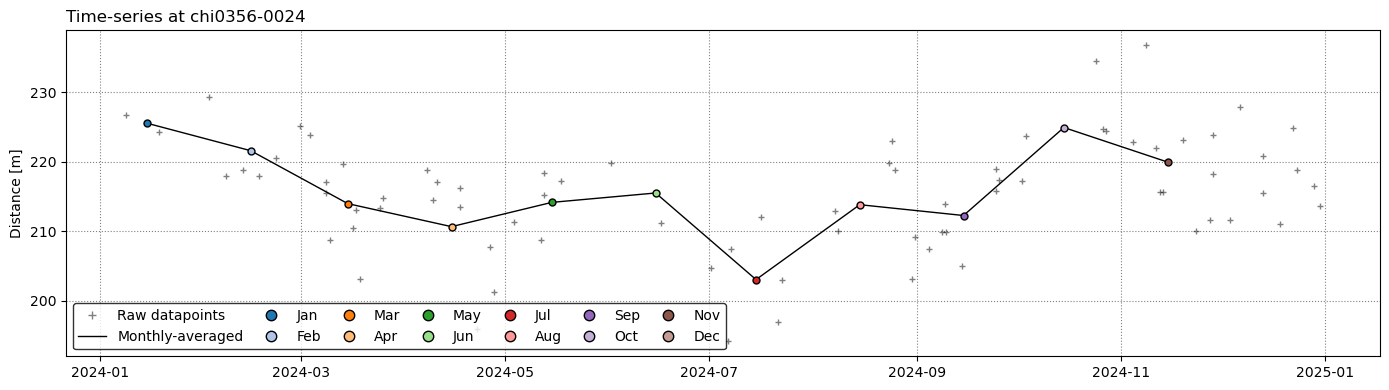

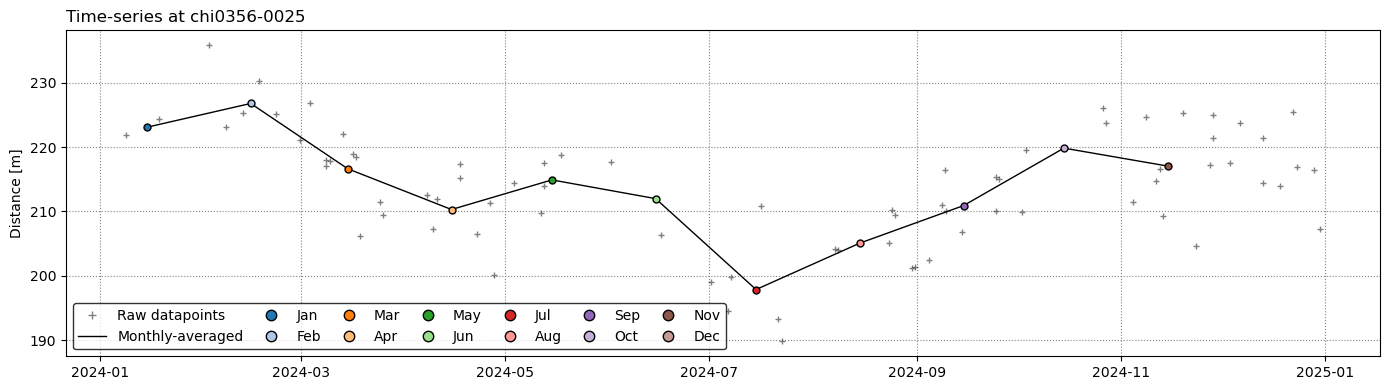

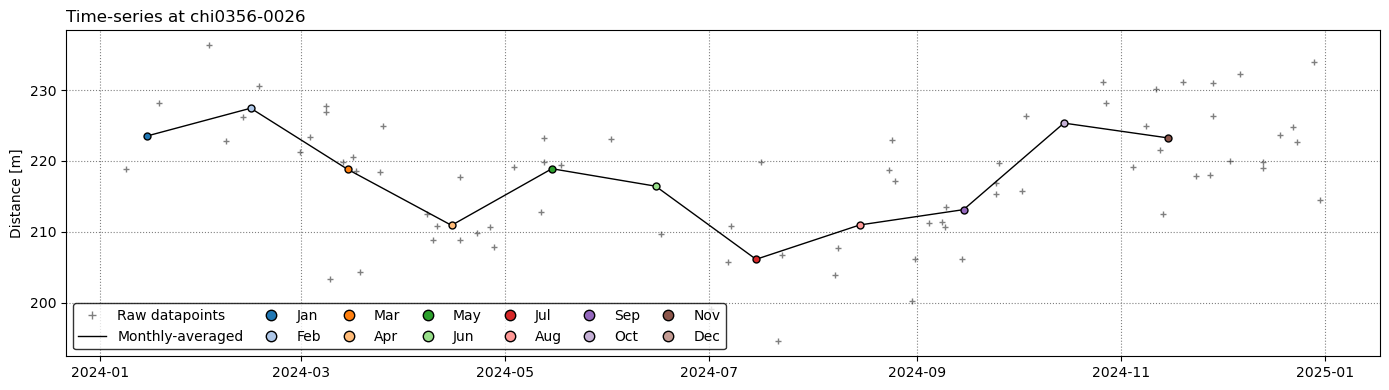

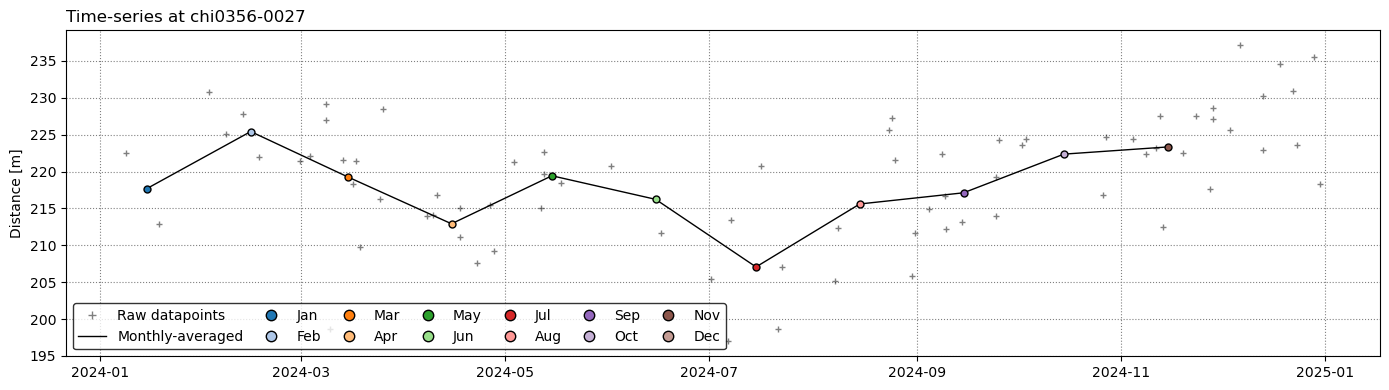

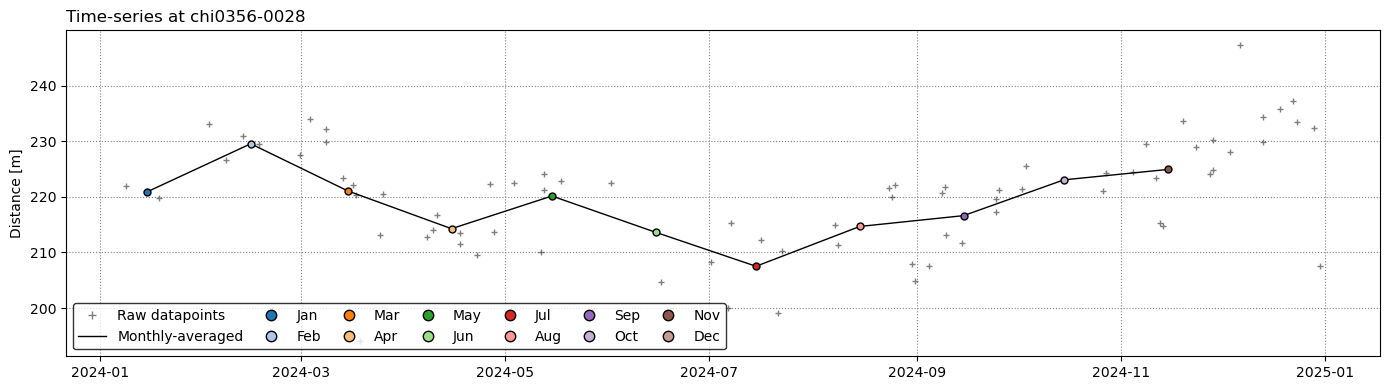

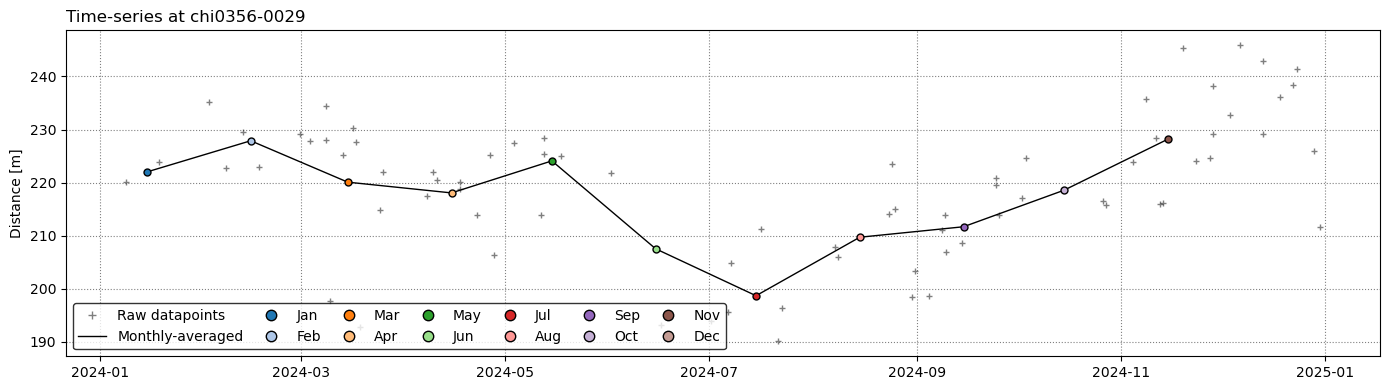

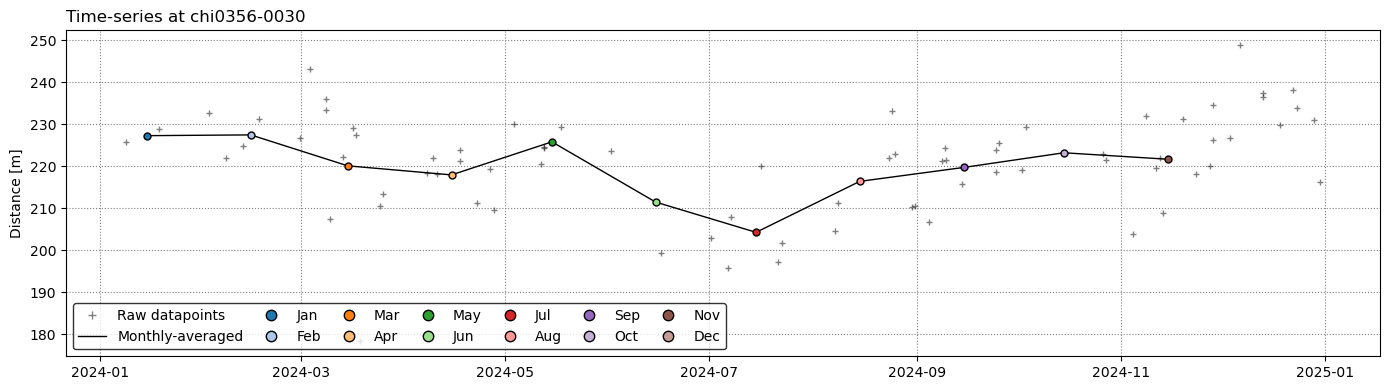

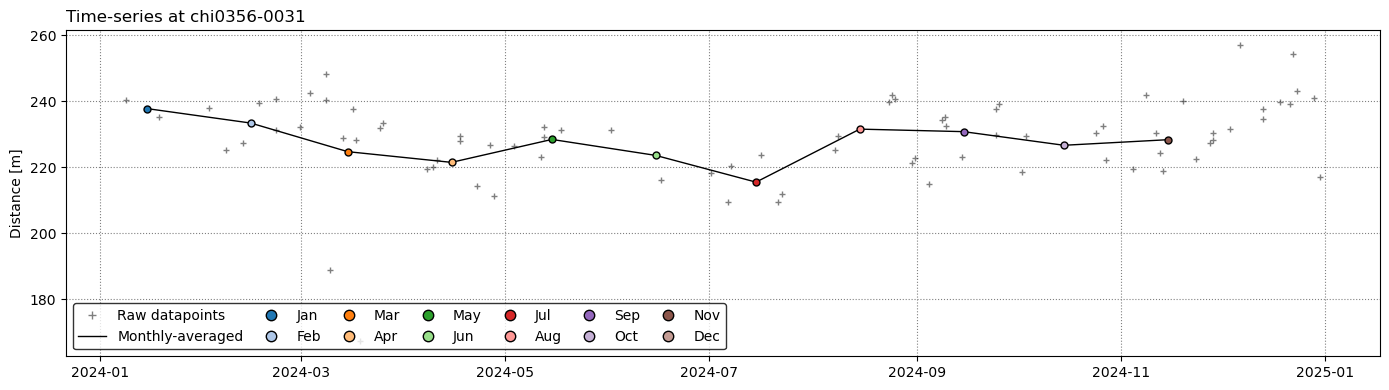

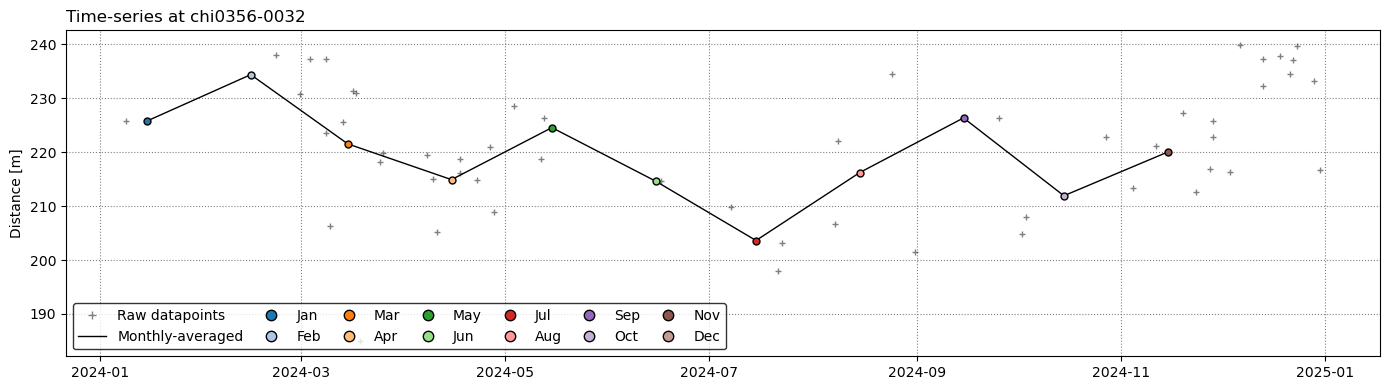

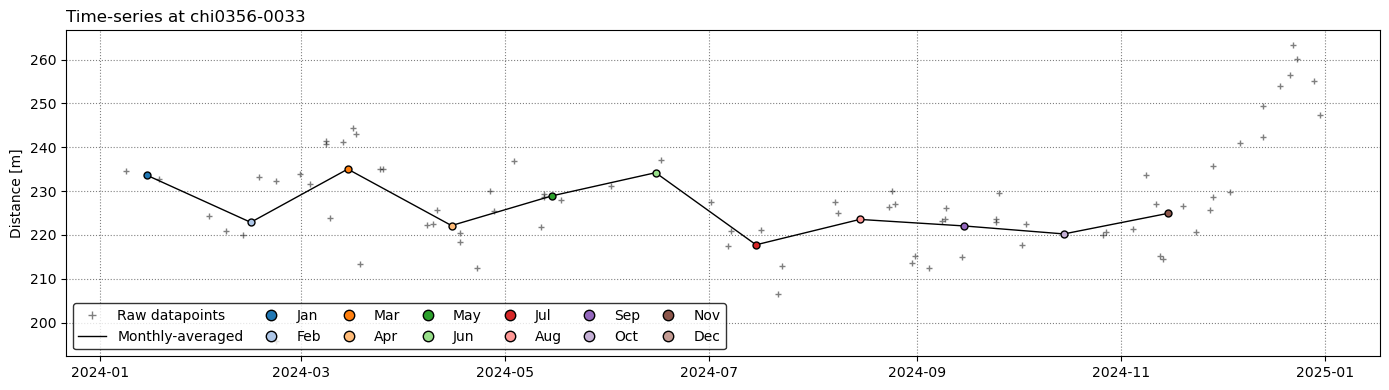

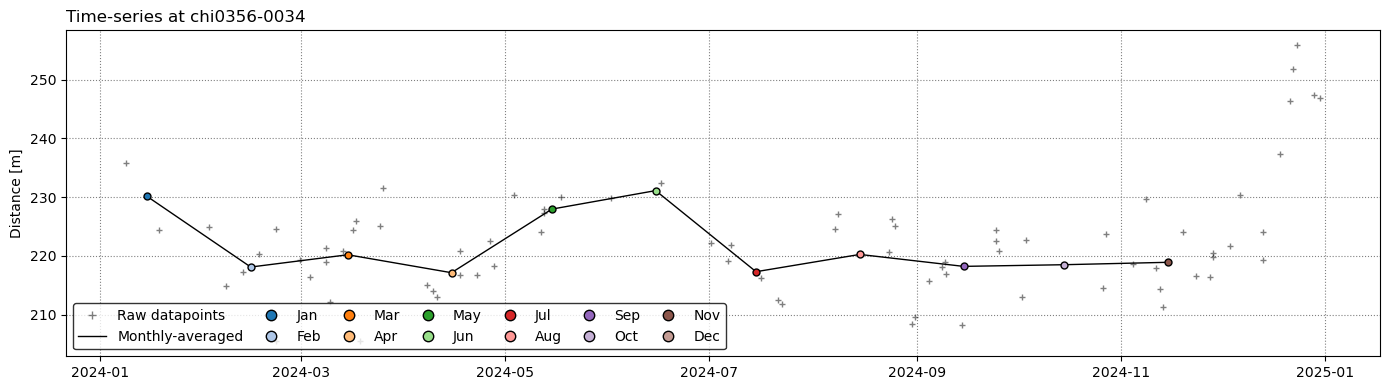

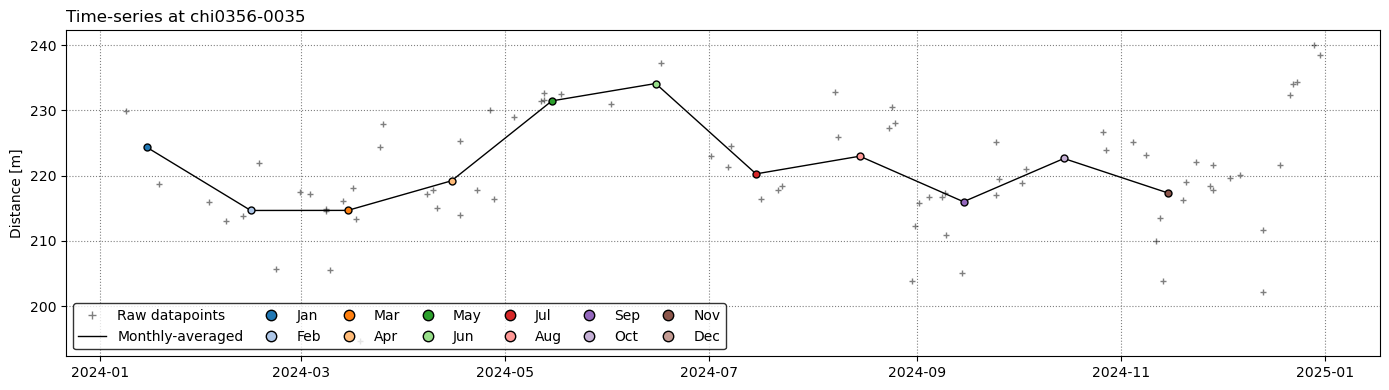

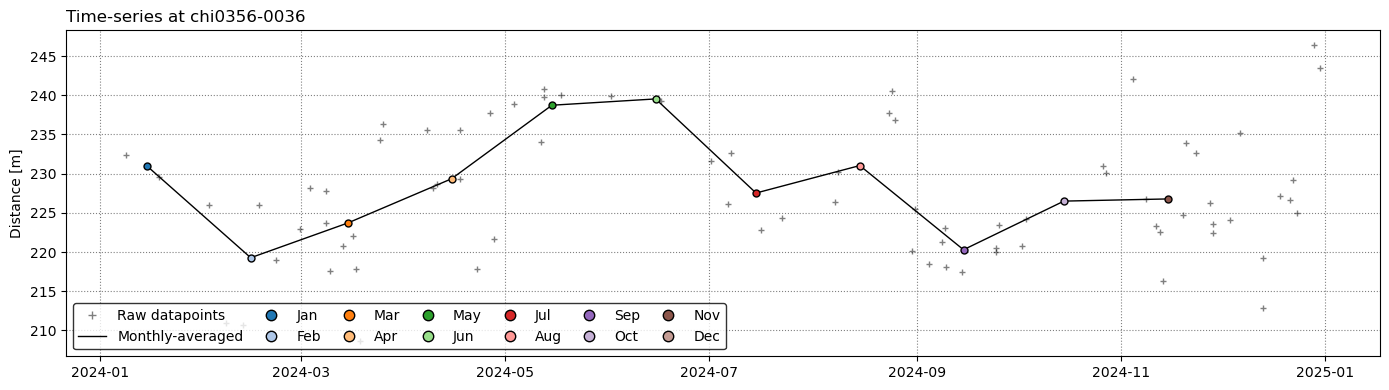

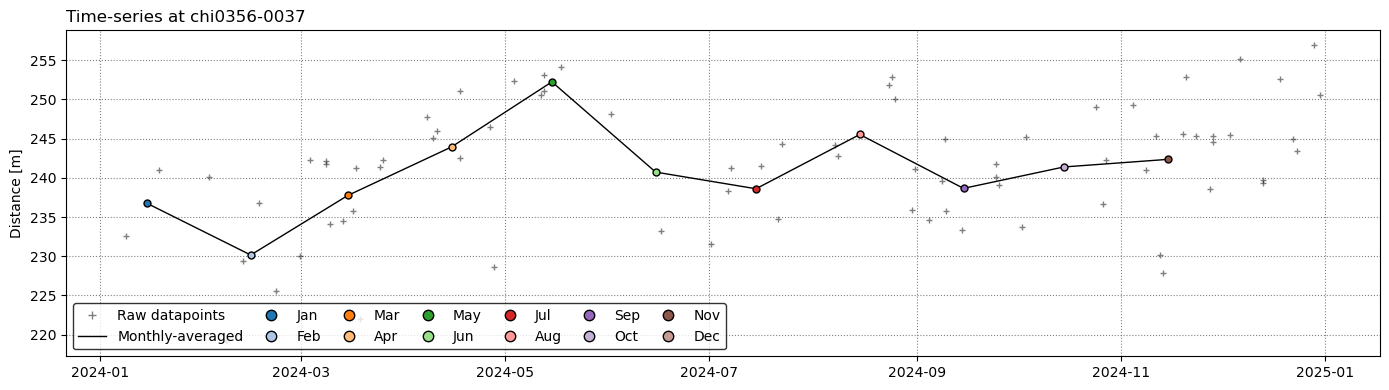

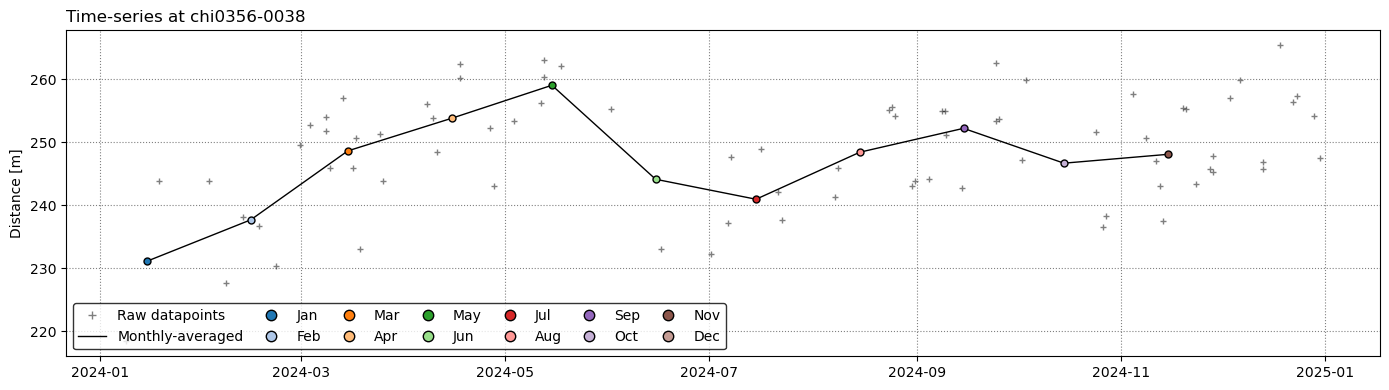

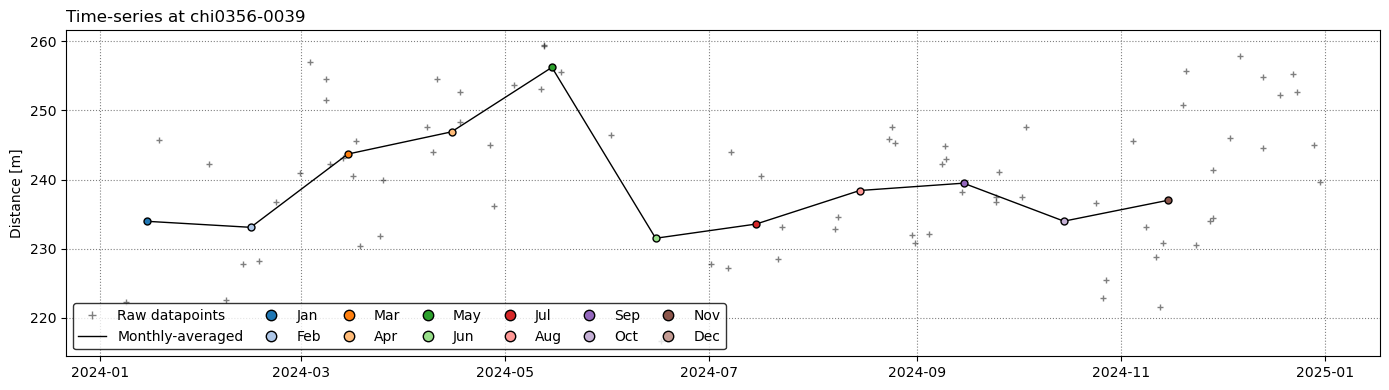

In [79]:
%matplotlib inline
# Obtener el mapa de colores para los meses
month_colors = plt.cm.get_cmap('tab20')

# Ruta para guardar resultados
output_dir = os.path.join(settings['inputs']['filepath'],
                          settings['inputs']['sitename'],
                          "Resultados",
                          "Transectos_Mensual")
os.makedirs(output_dir, exist_ok=True)  # Crear directorio si no existe

# Procesar cada transecto
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # Remover valores NaN
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan]

    # Calcular promedios mensuales
    dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)

    # Crear gráfico de promedios mensuales
    fig, ax = plt.subplots(1, 1, figsize=[14, 4], tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title(f'Time-series at {key}', x=0, ha='left')
    ax.set(ylabel='Distance [m]')
    ax.plot(dates_nonan, chainage, '+', lw=1, color='k', mfc='w', ms=4, alpha=0.5, label='Raw datapoints')
    ax.plot(dates_month, chainage_month, '-', lw=1, color='k', mfc='w', ms=4, label='Monthly-averaged')
    for k, month in enumerate(dict_month.keys()):
        ax.plot(
            dict_month[month]['dates'], dict_month[month]['chainages'],
            'o', mec='k', color=month_colors(k), label=month, ms=5
        )
    ax.legend(loc='lower left', ncol=7, markerscale=1.5, frameon=True, edgecolor='k', columnspacing=1)

    # Guardar figura individual
    figure_path = os.path.join(output_dir, f"monthly_{key}.png")
    plt.savefig(figure_path, dpi=300)
    print(f"Figura de promedios mensuales guardada en: {figure_path}")
